In [3]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset,AspcapDataset

from apoNN.src.utils import generate_loss_with_masking
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
allStar =  load("allStar_training_clean")[:10000]
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

In [5]:
upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
c_outliercut = allStar["C_FE"]>-5
n_outliercut = allStar["n_fe"]>-5
o_outliercut = allStar["O_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
k_outliercut = allStar["k_fe"]>-5
ca_outliercut = allStar["ca_fe"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
mn_outliercut = allStar["mn_fe"]>-5
co_outliercut = allStar["co_fe"]>-5
n_outliercut = allStar["n_fe"]>-5
ni_outliercut = allStar["ni_fe"]>-5
cu_outliercut = allStar["cu_fe"]>-5


combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut & ca_outliercut & n_outliercut & mn_outliercut & k_outliercut & co_outliercut & ni_outliercut & cu_outliercut


In [6]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Ca_FE","Ti_Fe","N_FE","K_FE","Mn_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE","CO_FE"] 
y = vector.Vector(np.array([allStar[combined_cut][param] for param in considered_parameters])[:,:n_data].T)

In [247]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/aspcap/dim/z10/ae_29750.p")

In [248]:
#autoencoder.intermediate_activation=None

In [249]:
z = vector.LatentVector(dataset,autoencoder,n_data)
z_cut = vector.Vector(z.raw[combined_cut[:n_data]])

In [250]:
y_train = vector.Vector(y.raw[:5000])
y_val = vector.Vector(y.raw[5000:])

In [236]:
z_cut_train = vector.Vector(z_cut.raw[:5000])
z_cut_val = vector.Vector(z_cut.raw[5000:])

In [237]:
w = vector.LinearTransformation(z_cut_train,y_train)
nonlinear_w = vector.NonLinearTransformation(z_cut_train,y_train)
nonlinear_w.fit(n_epochs=500)

err:0.09307809174060822
err:0.0808384120464325
err:0.08098072558641434
err:0.07414562255144119
err:0.06746917217969894
err:0.06482397764921188
err:0.05355433374643326
err:0.05147770419716835
err:0.049958549439907074
err:0.046159397810697556
err:0.041135262697935104
err:0.04056990146636963
err:0.034762077033519745
err:0.03075745329260826
err:0.040707968175411224
err:0.031263455748558044
err:0.023460479453206062
err:0.023427726700901985
err:0.019781354814767838
err:0.022047758102416992
err:0.021919507533311844
err:0.021881287917494774
err:0.02306894026696682
err:0.01784038171172142
err:0.018985608592629433
err:0.019992677494883537
err:0.01759246736764908
err:0.017198596149683
err:0.02135547250509262
err:0.018978942185640335
err:0.02261396311223507
err:0.023900354281067848
err:0.030680954456329346
err:0.024267740547657013
err:0.019161373376846313
err:0.01967601850628853
err:0.023285415023565292
err:0.0169722568243742
err:0.01539092231541872
err:0.015378628857433796
err:0.01648755371570587

err:0.013016177341341972
err:0.014108068309724331
err:0.011401612311601639
err:0.013063210994005203
err:0.012623961083590984
err:0.016494031995534897
err:0.010950353927910328
err:0.01086723804473877
err:0.011392873711884022
err:0.013534587807953358
err:0.011847218498587608
err:0.012279446236789227
err:0.011616960167884827
err:0.01248539611697197
err:0.012544509023427963
err:0.012840167619287968
err:0.012614617124199867
err:0.012791693210601807
err:0.014413676224648952
err:0.011325069703161716
err:0.014980520121753216
err:0.011415409855544567
err:0.010652832686901093
err:0.01032024621963501
err:0.009665156714618206
err:0.010121981613337994
err:0.010251437313854694
err:0.010806648060679436
err:0.012967387214303017
err:0.010173588059842587
err:0.0114842988550663
err:0.010901001282036304
err:0.01019983272999525
err:0.010409916751086712
err:0.013478363864123821
err:0.011404981836676598
err:0.015598519705235958
err:0.016021983698010445
err:0.01837998814880848
err:0.0171723123639822
err:0.013

err:0.01255241222679615
err:0.009290840476751328
err:0.011945551261305809
err:0.013135102577507496
err:0.010596436448395252
err:0.011932585388422012
err:0.011740154586732388
err:0.015302739106118679
err:0.010152813047170639
err:0.010205069556832314
err:0.010493351146578789
err:0.012808664701879025
err:0.011112788692116737
err:0.011353750713169575
err:0.01075516827404499
err:0.011805837042629719
err:0.011639302596449852
err:0.01203499548137188
err:0.011953157372772694
err:0.011832818388938904
err:0.013452807441353798
err:0.0106304120272398
err:0.01354814413934946
err:0.010456831194460392
err:0.009859418496489525
err:0.00962015800178051
err:0.009145152755081654
err:0.009539209306240082
err:0.009644769132137299
err:0.01009439304471016
err:0.012073241174221039
err:0.009428851306438446
err:0.010804797522723675
err:0.010105939581990242
err:0.009532539173960686
err:0.009432824328541756
err:0.012754890136420727
err:0.01086154580116272
err:0.014545614831149578
err:0.014896723441779613
err:0.016

err:0.010722161270678043
err:0.01046158280223608
err:0.009950068779289722
err:0.010788322426378727
err:0.010387503542006016
err:0.011666585691273212
err:0.00875809509307146
err:0.01103480439633131
err:0.012383705005049706
err:0.00999484583735466
err:0.011077111586928368
err:0.011090127751231194
err:0.014384754933416843
err:0.009495863690972328
err:0.009624565951526165
err:0.009815959259867668
err:0.012246892787516117
err:0.010471859015524387
err:0.010616003535687923
err:0.010041078552603722
err:0.011132250539958477
err:0.010874638333916664
err:0.011442568153142929
err:0.01140046026557684
err:0.011012681759893894
err:0.01261959969997406
err:0.009983115829527378
err:0.012410684488713741
err:0.009700332768261433
err:0.009182858280837536
err:0.009046207182109356
err:0.00871569849550724
err:0.009102188050746918
err:0.009168390184640884
err:0.009556889533996582
err:0.011415170505642891
err:0.008886421099305153
err:0.010196220129728317
err:0.009453123435378075
err:0.008975999429821968
err:0.0

err:0.013718418776988983
err:0.010696434415876865
err:0.0106379808858037
err:0.012410675175487995
err:0.00999302975833416
err:0.0099722221493721
err:0.009205509908497334
err:0.0100626265630126
err:0.009679433889687061
err:0.010888859629631042
err:0.008256970904767513
err:0.010255510918796062
err:0.011751215904951096
err:0.009470942430198193
err:0.0103561170399189
err:0.010501226410269737
err:0.013533518649637699
err:0.008957560174167156
err:0.009066769853234291
err:0.009235171601176262
err:0.011701499111950397
err:0.009845110587775707
err:0.009964792989194393
err:0.009452341124415398
err:0.010528376325964928
err:0.010200483724474907
err:0.010989946313202381
err:0.010903185233473778
err:0.010315223596990108
err:0.011808488517999649
err:0.009399624541401863
err:0.011399589478969574
err:0.009084503166377544
err:0.008588929660618305
err:0.008536227978765965
err:0.008363199420273304
err:0.008740351535379887
err:0.008712917566299438
err:0.009092996828258038
err:0.010813526809215546
err:0.008

err:0.007727468851953745
err:0.011058512143790722
err:0.009399676695466042
err:0.011902527883648872
err:0.012206434272229671
err:0.013750167563557625
err:0.012655133381485939
err:0.010111323557794094
err:0.010026735253632069
err:0.011537834070622921
err:0.009407402016222477
err:0.009594297036528587
err:0.008535176515579224
err:0.009467813186347485
err:0.0090875793248415
err:0.010256443172693253
err:0.007819358259439468
err:0.009586550295352936
err:0.011164573021233082
err:0.008996108546853065
err:0.009694911539554596
err:0.009943992830812931
err:0.012851622886955738
err:0.008526620455086231
err:0.008594614453613758
err:0.00872855819761753
err:0.011197621934115887
err:0.009318639524281025
err:0.009422331117093563
err:0.008948640897870064
err:0.010003304108977318
err:0.009617945179343224
err:0.01058613508939743
err:0.010443955659866333
err:0.009744886308908463
err:0.011097168549895287
err:0.00892123393714428
err:0.010562117211520672
err:0.008600225672125816
err:0.008106748573482037
err:0

err:0.00986223854124546
err:0.0076880319975316525
err:0.008710072375833988
err:0.007968592457473278
err:0.007628080900758505
err:0.007354553788900375
err:0.010500306263566017
err:0.008904686197638512
err:0.011073238216340542
err:0.011418880894780159
err:0.012835470028221607
err:0.011745025403797626
err:0.009640045464038849
err:0.009537487290799618
err:0.010781686753034592
err:0.008961736224591732
err:0.009294094517827034
err:0.00798332691192627
err:0.008998353965580463
err:0.008640754967927933
err:0.009805306792259216
err:0.007479546125978231
err:0.009024603292346
err:0.010620445013046265
err:0.008616666309535503
err:0.009131438098847866
err:0.009451955556869507
err:0.01231163926422596
err:0.008204353973269463
err:0.008194523863494396
err:0.008334674872457981
err:0.010783940553665161
err:0.008894503116607666
err:0.008976593613624573
err:0.008532755076885223
err:0.00957956351339817
err:0.009135670028626919
err:0.010237660259008408
err:0.010077595710754395
err:0.009320778772234917
err:0.

err:0.007631420623511076
err:0.007959024980664253
err:0.0076511697843670845
err:0.00819543655961752
err:0.009506193920969963
err:0.007424923591315746
err:0.00835143867880106
err:0.007652596570551395
err:0.007348101586103439
err:0.007092941086739302
err:0.010055087506771088
err:0.008476807735860348
err:0.010420803911983967
err:0.010803158394992352
err:0.012124079279601574
err:0.011028271168470383
err:0.009269505739212036
err:0.009150855243206024
err:0.010187502019107342
err:0.008660897612571716
err:0.00905506033450365
err:0.007601558230817318
err:0.008660183288156986
err:0.00835034903138876
err:0.009508962742984295
err:0.0072550042532384396
err:0.008632013574242592
err:0.010185949504375458
err:0.008348788134753704
err:0.00872094091027975
err:0.009069896303117275
err:0.011920482851564884
err:0.00800301693379879
err:0.007887923158705235
err:0.008044094778597355
err:0.010457376018166542
err:0.008585638366639614
err:0.008630339056253433
err:0.008205143734812737
err:0.009278318844735622
err:

err:0.008096449077129364
err:0.009203988127410412
err:0.007806119974702597
err:0.00733250891789794
err:0.007261247839778662
err:0.007480826694518328
err:0.007791793905198574
err:0.007410306017845869
err:0.008016071282327175
err:0.009235341101884842
err:0.007232890464365482
err:0.00809856690466404
err:0.007441370282322168
err:0.0071741146966814995
err:0.006899637170135975
err:0.00971461646258831
err:0.00813423190265894
err:0.009956622496247292
err:0.010390625335276127
err:0.011570103466510773
err:0.010480906814336777
err:0.008984879590570927
err:0.008853833191096783
err:0.009748836047947407
err:0.008429713547229767
err:0.008857064880430698
err:0.007333631627261639
err:0.008402392268180847
err:0.008143877610564232
err:0.009292017668485641
err:0.007117611821740866
err:0.00836107786744833
err:0.009856735356152058
err:0.008159701712429523
err:0.008429201319813728
err:0.008789612911641598
err:0.011620903387665749
err:0.007852491922676563
err:0.007657072506844997
err:0.007829771377146244
err:

err:0.008228595368564129
err:0.007813449017703533
err:0.008922414854168892
err:0.008309719152748585
err:0.009673751890659332
err:0.009501921944320202
err:0.008632587268948555
err:0.009648734703660011
err:0.00790497474372387
err:0.008939162828028202
err:0.007678421214222908
err:0.007170472759753466
err:0.007086290046572685
err:0.00738413305953145
err:0.007655720226466656
err:0.0072289216332137585
err:0.007887575775384903
err:0.0090116485953331
err:0.007090702187269926
err:0.007920627482235432
err:0.0072830659337341785
err:0.007053271401673555
err:0.00673920102417469
err:0.0094755245372653
err:0.007879212498664856
err:0.009620781056582928
err:0.010086102411150932
err:0.011160094290971756
err:0.010080079548060894
err:0.008759166114032269
err:0.008633025921881199
err:0.009421899914741516
err:0.008240364491939545
err:0.008691597729921341
err:0.0071425954811275005
err:0.008206870406866074
err:0.007985145784914494
err:0.009131232276558876
err:0.0070124343037605286
err:0.008163947612047195
err

err:0.007911008782684803
err:0.008063350804150105
err:0.008448348380625248
err:0.011209585703909397
err:0.007636896800249815
err:0.007358442060649395
err:0.00754525838419795
err:0.009897289797663689
err:0.008024226874113083
err:0.008084828965365887
err:0.007656100671738386
err:0.008783922530710697
err:0.00814254954457283
err:0.009535634890198708
err:0.009370669722557068
err:0.00846491102129221
err:0.009503776207566261
err:0.0077377669513225555
err:0.008701389655470848
err:0.007576825097203255
err:0.007033847272396088
err:0.006948832422494888
err:0.00730887008830905
err:0.007540247868746519
err:0.007088385988026857
err:0.007777978666126728
err:0.008821369148790836
err:0.006975740659981966
err:0.007789025083184242
err:0.007158366963267326
err:0.0069615598767995834
err:0.006611588876694441
err:0.009301821701228619
err:0.0076859379187226295
err:0.009371507912874222
err:0.009830424562096596
err:0.01082262210547924
err:0.009782327339053154
err:0.00858369842171669
err:0.008454052731394768
err

err:0.00794959720224142
err:0.007792379707098007
err:0.00889062974601984
err:0.006846372038125992
err:0.00791231356561184
err:0.009232348762452602
err:0.0078076086938381195
err:0.007909388281404972
err:0.008316014893352985
err:0.011043593287467957
err:0.007549977861344814
err:0.007241613697260618
err:0.007428936660289764
err:0.009773396886885166
err:0.007898231968283653
err:0.007972678169608116
err:0.007527035195380449
err:0.008673438802361488
err:0.008001535199582577
err:0.009416934102773666
err:0.009250371716916561
err:0.00832265056669712
err:0.009378899820148945
err:0.007600521668791771
err:0.008504009805619717
err:0.007484161760658026
err:0.006918597500771284
err:0.006840049289166927
err:0.007248205132782459
err:0.007459193468093872
err:0.00697145564481616
err:0.007684026379138231
err:0.008651752956211567
err:0.006882836110889912
err:0.00768622849136591
err:0.0070706517435610294
err:0.006888111587613821
err:0.006500776391476393
err:0.009168105199933052
err:0.0075310030952095985
err

err:0.009068563580513
err:0.007418441586196423
err:0.009024495258927345
err:0.009468553587794304
err:0.010324839502573013
err:0.009344644844532013
err:0.008324258029460907
err:0.0082100136205554
err:0.008850693702697754
err:0.007846616208553314
err:0.008353672921657562
err:0.006823268719017506
err:0.007847374305129051
err:0.007705459371209145
err:0.0087880315259099
err:0.0067771440371870995
err:0.007824964821338654
err:0.009071105159819126
err:0.007712966296821833
err:0.00778026832267642
err:0.008208784274756908
err:0.010904094204306602
err:0.007480336353182793
err:0.007145673967897892
err:0.007325551938265562
err:0.009670238010585308
err:0.007788578514009714
err:0.007873333059251308
err:0.007415098138153553
err:0.008582709357142448
err:0.007878542877733707
err:0.009304405190050602
err:0.009137722663581371
err:0.008193719200789928
err:0.009276959113776684
err:0.007479269523173571
err:0.008342551998794079
err:0.0074039120227098465
err:0.0068163564428687096
err:0.006753201596438885
err:0

err:0.009198321029543877
err:0.0073923817835748196
err:0.008218138478696346
err:0.007346005644649267
err:0.006735975854098797
err:0.006690480746328831
err:0.0071451421827077866
err:0.007332443259656429
err:0.006798232439905405
err:0.007541005965322256
err:0.008385340683162212
err:0.006742379162460566
err:0.007528779096901417
err:0.006933713331818581
err:0.006783041637390852
err:0.006339664570987225
err:0.008976507000625134
err:0.0073126512579619884
err:0.008879992179572582
err:0.009312469512224197
err:0.010103565640747547
err:0.009145271964371204
err:0.008203129284083843
err:0.008105217479169369
err:0.008720840327441692
err:0.007740489207208157
err:0.008267727680504322
err:0.0067497617565095425
err:0.007758901454508305
err:0.0076303365640342236
err:0.008711808361113071
err:0.00672132708132267
err:0.007742060348391533
err:0.008927992545068264
err:0.007631420157849789
err:0.00767565006390214
err:0.008116058073937893
err:0.010765145532786846
err:0.007419621106237173
err:0.0070638209581375

err:0.009129693731665611
err:0.008973876014351845
err:0.007992728613317013
err:0.009119915775954723
err:0.007308103609830141
err:0.008085295557975769
err:0.007289018947631121
err:0.00665371073409915
err:0.006627090275287628
err:0.007091252598911524
err:0.007272827904671431
err:0.0067239184863865376
err:0.007480038329958916
err:0.008274367079138756
err:0.006682463921606541
err:0.007451553363353014
err:0.006865757517516613
err:0.006739146076142788
err:0.006270623300224543
err:0.00889621116220951
err:0.007222624961286783
err:0.00876059290021658
err:0.009174223989248276
err:0.009931227192282677
err:0.008976258337497711
err:0.008095241151750088
err:0.00801114458590746
err:0.008601677604019642
err:0.007648518308997154
err:0.00818445160984993
err:0.0066824788227677345
err:0.0076811304315924644
err:0.0075671980157494545
err:0.00864974595606327
err:0.0066651878878474236
err:0.007670505903661251
err:0.008805404417216778
err:0.007548784837126732
err:0.00758633716031909
err:0.008039158768951893
er

err:0.007642837241292
err:0.007167206145823002
err:0.008350138552486897
err:0.007606562692672014
err:0.009047536179423332
err:0.008898038417100906
err:0.00790404062718153
err:0.009057963266968727
err:0.007234096061438322
err:0.007970026694238186
err:0.007233128417283297
err:0.006581500638276339
err:0.006570938974618912
err:0.007048225961625576
err:0.007222172804176807
err:0.006658569443970919
err:0.007430891506373882
err:0.0081747742369771
err:0.00662660738453269
err:0.007377808913588524
err:0.006799838040024042
err:0.00670091575011611
err:0.00620874622836709
err:0.008822609670460224
err:0.0071438695304095745
err:0.008657023310661316
err:0.009049282409250736
err:0.00977774616330862
err:0.00882736872881651
err:0.007992953062057495
err:0.007930636405944824
err:0.0085000516846776
err:0.007564169354736805
err:0.008111714385449886
err:0.0066199591383337975
err:0.007609158754348755
err:0.007509434130042791
err:0.00859337393194437
err:0.006620415952056646
err:0.007604705169796944
err:0.008687

err:0.007047133985906839
err:0.009351936168968678
err:0.007519993931055069
err:0.007578880526125431
err:0.007090917322784662
err:0.008285620249807835
err:0.007524312939494848
err:0.008964738808572292
err:0.008822479285299778
err:0.00782602559775114
err:0.009002085775136948
err:0.0071669030003249645
err:0.007864157669246197
err:0.0071789575740695
err:0.006513883825391531
err:0.006518438458442688
err:0.00700986385345459
err:0.007174312137067318
err:0.00660233898088336
err:0.007390436716377735
err:0.008081921376287937
err:0.006571774836629629
err:0.00731365941464901
err:0.00674280384555459
err:0.006660345010459423
err:0.006154556758701801
err:0.008757805451750755
err:0.007068193517625332
err:0.008560681715607643
err:0.008946637623012066
err:0.009631142020225525
err:0.008694006130099297
err:0.007886623032391071
err:0.007868052460253239
err:0.008412831462919712
err:0.0074895573779940605
err:0.008053004741668701
err:0.006555542349815369
err:0.007541996892541647
err:0.00745563255622983
err:0.

err:0.008508006110787392
err:0.0073321303352713585
err:0.00738475052639842
err:0.007838626392185688
err:0.010322459042072296
err:0.007241607643663883
err:0.00682630343362689
err:0.006977682467550039
err:0.009292387403547764
err:0.007463087793439627
err:0.007522446569055319
err:0.007022195030003786
err:0.00822356529533863
err:0.00745408097282052
err:0.008889516815543175
err:0.008744404651224613
err:0.007758357096463442
err:0.008940789848566055
err:0.007103418931365013
err:0.00777201633900404
err:0.007132357452064753
err:0.0064493329264223576
err:0.006471423432230949
err:0.006968196481466293
err:0.007130178157240152
err:0.006553563289344311
err:0.007352706044912338
err:0.007995535619556904
err:0.006522308103740215
err:0.007252141833305359
err:0.006694090086966753
err:0.006621102802455425
err:0.006108267232775688
err:0.008697509765625
err:0.007001913618296385
err:0.00846943911164999
err:0.008853519335389137
err:0.00948884803801775
err:0.008561886847019196
err:0.007783057168126106
err:0.00

err:0.00720225041732192
err:0.006782227195799351
err:0.0069143339060246944
err:0.009235858917236328
err:0.007413350045681
err:0.007469313219189644
err:0.0069610257633030415
err:0.008164191618561745
err:0.007390356156975031
err:0.008820982649922371
err:0.008671252056956291
err:0.007689598947763443
err:0.008881804533302784
err:0.007047854829579592
err:0.007686639204621315
err:0.007092648185789585
err:0.006387933157384396
err:0.006428863853216171
err:0.0069331154227256775
err:0.007090593222528696
err:0.0065079908818006516
err:0.007319699972867966
err:0.007917356677353382
err:0.006475021596997976
err:0.007198633626103401
err:0.006644910667091608
err:0.006588679272681475
err:0.006063720211386681
err:0.008641166612505913
err:0.006943464279174805
err:0.008392763324081898
err:0.008770503103733063
err:0.009352374821901321
err:0.008443751372396946
err:0.007683728821575642
err:0.007765966933220625
err:0.008262868970632553
err:0.007348386105149984
err:0.007947695441544056
err:0.006448162253946066


err:0.006392151582986116
err:0.006895329337567091
err:0.007057386450469494
err:0.006464137230068445
err:0.007286750245839357
err:0.00784966442734003
err:0.006425406783819199
err:0.0071456339210271835
err:0.006597484461963177
err:0.00655611976981163
err:0.006024399306625128
err:0.008586149662733078
err:0.006888587027788162
err:0.008312991820275784
err:0.008694116957485676
err:0.009236183017492294
err:0.00833524763584137
err:0.0075931185856461525
err:0.007711957674473524
err:0.008197891525924206
err:0.007281413767486811
err:0.007890775799751282
err:0.006397739984095097
err:0.007360571995377541
err:0.007312785368412733
err:0.008374319411814213
err:0.006470598746091127
err:0.007395442575216293
err:0.008316813968122005
err:0.0071913572028279305
err:0.0072516039945185184
err:0.007712787017226219
err:0.010095668956637383
err:0.007152367848902941
err:0.006737799383699894
err:0.0068467664532363415
err:0.009176949970424175
err:0.0073636253364384174
err:0.007410628255456686
err:0.0068934774026274

err:0.007122484967112541
err:0.006708233151584864
err:0.006796864792704582
err:0.009134223684668541
err:0.007328043691813946
err:0.007367508485913277
err:0.00684739975258708
err:0.008045077323913574
err:0.007266639266163111
err:0.00870221946388483
err:0.008543634787201881
err:0.007565774954855442
err:0.008765366859734058
err:0.006946866400539875
err:0.007533865049481392
err:0.00701460475102067
err:0.006278327666223049
err:0.006362122483551502
err:0.006854516454041004
err:0.00702410563826561
err:0.006420991383492947
err:0.007256962824612856
err:0.007785833440721035
err:0.00637905253097415
err:0.007100643590092659
err:0.006553096231073141
err:0.006527333986014128
err:0.005980934482067823
err:0.008535625413060188
err:0.006837958469986916
err:0.008241103030741215
err:0.008623715490102768
err:0.009132804349064827
err:0.00823977030813694
err:0.007511603180319071
err:0.007661933079361916
err:0.008134804666042328
err:0.0072179329581558704
err:0.007839277386665344
err:0.006353640928864479
err:0

err:0.00708145834505558
err:0.007150588091462851
err:0.007609216962009668
err:0.009930663742125034
err:0.007092250976711512
err:0.00667670788243413
err:0.006745089776813984
err:0.009087344631552696
err:0.007285927422344685
err:0.007322434335947037
err:0.006793923210352659
err:0.007994523271918297
err:0.007215988356620073
err:0.008651422336697578
err:0.008491343818604946
err:0.007508908398449421
err:0.00871360395103693
err:0.006901305168867111
err:0.0074675679206848145
err:0.006982221733778715
err:0.006220347248017788
err:0.006329095922410488
err:0.006814365740865469
err:0.006988589186221361
err:0.006382598076015711
err:0.007226702757179737
err:0.007720831781625748
err:0.006335109006613493
err:0.00706196203827858
err:0.006509730126708746
err:0.006503293756395578
err:0.0059363883920013905
err:0.00848785974085331
err:0.006789268925786018
err:0.008175436407327652
err:0.008552148006856441
err:0.00904058013111353
err:0.008152401074767113
err:0.007428997196257114
err:0.007614473812282085
err:

err:0.008266332559287548
err:0.006390166003257036
err:0.0072511485777795315
err:0.008093645796179771
err:0.0070214467123150826
err:0.007101330440491438
err:0.007560931611806154
err:0.009851674549281597
err:0.007062370888888836
err:0.006643655709922314
err:0.006691991817206144
err:0.00904138758778572
err:0.007245887070894241
err:0.007280487567186356
err:0.006740730721503496
err:0.007943267934024334
err:0.007168533746153116
err:0.008607073687016964
err:0.008444449864327908
err:0.007450514007359743
err:0.008657557889819145
err:0.006859870627522469
err:0.007403977680951357
err:0.0069488901644945145
err:0.006171537097543478
err:0.006301193498075008
err:0.006777578964829445
err:0.0069556450471282005
err:0.00634649908170104
err:0.007199469488114119
err:0.007663740776479244
err:0.0062982202507555485
err:0.007019849494099617
err:0.0064729866571724415
err:0.006478604394942522
err:0.005897230934351683
err:0.008442153222858906
err:0.006746372673660517
err:0.008115062490105629
err:0.008485020138323

err:0.0075373053550720215
err:0.007976057007908821
err:0.0070679145865142345
err:0.007708115037530661
err:0.006244563031941652
err:0.007169855758547783
err:0.007170259021222591
err:0.008225440979003906
err:0.006359068676829338
err:0.00720515800639987
err:0.008021704852581024
err:0.006968469824641943
err:0.007059871219098568
err:0.007516041863709688
err:0.009780341759324074
err:0.0070404415018856525
err:0.006611695978790522
err:0.006638651248067617
err:0.008995790965855122
err:0.007207168266177177
err:0.0072409724816679955
err:0.006691385060548782
err:0.007891368120908737
err:0.007124383468180895
err:0.008566990494728088
err:0.00839159544557333
err:0.007395430933684111
err:0.008607589639723301
err:0.0068213664926588535
err:0.007345012854784727
err:0.006914781406521797
err:0.006121666636317968
err:0.006269915960729122
err:0.006746402010321617
err:0.006926089059561491
err:0.006313115358352661
err:0.007176612038165331
err:0.007609026040881872
err:0.0062606437131762505
err:0.006982640828937

err:0.008012405596673489
err:0.008375551551580429
err:0.008803349919617176
err:0.00790717825293541
err:0.007202754262834787
err:0.007496371865272522
err:0.007929215207695961
err:0.007024385500699282
err:0.007665686774998903
err:0.006205926649272442
err:0.007123981136828661
err:0.007137836888432503
err:0.008187085390090942
err:0.006328074261546135
err:0.0071602980606257915
err:0.007950947619974613
err:0.006916167214512825
err:0.007020213175565004
err:0.0074751549400389194
err:0.009715010412037373
err:0.007019327022135258
err:0.0065816352143883705
err:0.006589604541659355
err:0.00894539337605238
err:0.007167349103838205
err:0.007202482316643
err:0.006645532790571451
err:0.00783758144825697
err:0.007083803880959749
err:0.008529982529580593
err:0.008345403708517551
err:0.007347387727349997
err:0.008558414876461029
err:0.006783591583371162
err:0.007290985435247421
err:0.0068803769536316395
err:0.006081259343773127
err:0.006240525748580694
err:0.0067171393893659115
err:0.006898002699017525
e

err:0.006387705914676189
err:0.006417522672563791
err:0.0057997857220470905
err:0.008329865522682667
err:0.006643869914114475
err:0.007960749790072441
err:0.008321138098835945
err:0.008729994297027588
err:0.00783155020326376
err:0.007131377700716257
err:0.007461594883352518
err:0.00788573082536459
err:0.00698481360450387
err:0.007627910003066063
err:0.006167626474052668
err:0.0070813605561852455
err:0.007106461562216282
err:0.008152811788022518
err:0.006299060769379139
err:0.007121668662875891
err:0.007887160405516624
err:0.00686477730050683
err:0.006984107196331024
err:0.007435966748744249
err:0.009655935689806938
err:0.006997052580118179
err:0.006553645711392164
err:0.006543437484651804
err:0.008902324363589287
err:0.007131855469197035
err:0.007165634538978338
err:0.006595651153475046
err:0.007791297510266304
err:0.0070422044955194
err:0.008497452363371849
err:0.008299523033201694
err:0.00730537623167038
err:0.008517301641404629
err:0.00674515962600708
err:0.007245011627674103
err:0.

err:0.00623609684407711
err:0.007106826640665531
err:0.00747092068195343
err:0.006171739660203457
err:0.006875091232359409
err:0.00635890755802393
err:0.006397631950676441
err:0.005771243013441563
err:0.008294060826301575
err:0.006610493641346693
err:0.007911521010100842
err:0.00825997069478035
err:0.008664462715387344
err:0.007768247276544571
err:0.007068837992846966
err:0.007427918259054422
err:0.007850360125303268
err:0.006943584885448217
err:0.007585553452372551
err:0.006131964735686779
err:0.007038421928882599
err:0.007078222930431366
err:0.008124708198010921
err:0.006274044513702393
err:0.007078289985656738
err:0.007825186476111412
err:0.006820749957114458
err:0.0069503202103078365
err:0.007397637702524662
err:0.009590876288712025
err:0.006979659199714661
err:0.0065297288820147514
err:0.006499032955616713
err:0.008857348002493382
err:0.00709337554872036
err:0.007131131831556559
err:0.006547740660607815
err:0.007741937413811684
err:0.0070043099112808704
err:0.008463156409561634
er

err:0.0068007344380021095
err:0.005965617951005697
err:0.006164563819766045
err:0.006639348343014717
err:0.006829841993749142
err:0.006212776992470026
err:0.007081281393766403
err:0.007431468460708857
err:0.006143784150481224
err:0.006840934045612812
err:0.006329704076051712
err:0.006380164995789528
err:0.005744475871324539
err:0.008263344876468182
err:0.006578537635505199
err:0.007866529747843742
err:0.008203745819628239
err:0.00859815627336502
err:0.007709202356636524
err:0.0070014838129282
err:0.007393924985080957
err:0.007813959382474422
err:0.006897639483213425
err:0.00754591217264533
err:0.006099266931414604
err:0.006995992735028267
err:0.0070496490225195885
err:0.00809346605092287
err:0.006246598903089762
err:0.007035343907773495
err:0.007764619775116444
err:0.006775059271603823
err:0.006920653395354748
err:0.007362121716141701
err:0.009525977075099945
err:0.006960738450288773
err:0.006505684461444616
err:0.006457532290369272
err:0.008820218034088612
err:0.007055547554045916
err

err:0.008185939863324165
err:0.007198881823569536
err:0.008415402844548225
err:0.0066498820669949055
err:0.0071370042860507965
err:0.006781021598726511
err:0.0059303464367985725
err:0.006140855140984058
err:0.006617202423512936
err:0.006805769167840481
err:0.006188518833369017
err:0.00705135241150856
err:0.007397043518722057
err:0.006117165554314852
err:0.006811470724642277
err:0.006305543705821037
err:0.006364408414810896
err:0.005720991641283035
err:0.008235331624746323
err:0.006549244746565819
err:0.007820251397788525
err:0.008150996640324593
err:0.00853518396615982
err:0.0076576839201152325
err:0.0069381799548864365
err:0.007364464923739433
err:0.007777879014611244
err:0.006859163753688335
err:0.0075114089995622635
err:0.006069764494895935
err:0.006957560777664185
err:0.007023113314062357
err:0.008061597123742104
err:0.006223803851753473
err:0.006994341500103474
err:0.007707783952355385
err:0.006732965353876352
err:0.0068925656378269196
err:0.007321205455809832
err:0.00946155190467

err:0.006991859059780836
err:0.007035069167613983
err:0.006424163468182087
err:0.00761423772200942
err:0.006898850668221712
err:0.00837037619203329
err:0.008146187290549278
err:0.007165347225964069
err:0.008383502252399921
err:0.006622929126024246
err:0.007104791235178709
err:0.006766405422240496
err:0.005899644922465086
err:0.00612083962187171
err:0.006594725418835878
err:0.006782439537346363
err:0.006164580583572388
err:0.007025196682661772
err:0.0073643820360302925
err:0.0060936459340155125
err:0.006780514493584633
err:0.006282550282776356
err:0.006351519841700792
err:0.0056998212821781635
err:0.008207026869058609
err:0.006520082242786884
err:0.007781663443893194
err:0.008103061467409134
err:0.00847671553492546
err:0.007606053724884987
err:0.006875747349113226
err:0.00733213359490037
err:0.00774636585265398
err:0.00682046078145504
err:0.0074792103841900826
err:0.006039015017449856
err:0.006920018699020147
err:0.006996823009103537
err:0.008021470159292221
err:0.0062034353613853455
er

err:0.006909610237926245
err:0.006441696081310511
err:0.006351852789521217
err:0.008726201951503754
err:0.006957275792956352
err:0.007006173487752676
err:0.006385020446032286
err:0.007577052339911461
err:0.006861382629722357
err:0.008335348218679428
err:0.00810848269611597
err:0.0071339597925543785
err:0.008358366787433624
err:0.006594160571694374
err:0.007071459200233221
err:0.006749703083187342
err:0.005870417691767216
err:0.00609983503818512
err:0.006572420708835125
err:0.006760511547327042
err:0.0061418162658810616
err:0.006999954115599394
err:0.007330860011279583
err:0.006072803400456905
err:0.006751310545951128
err:0.0062571377493441105
err:0.0063370633870363235
err:0.0056808870285749435
err:0.008180207572877407
err:0.006494308356195688
err:0.007738498039543629
err:0.008057593367993832
err:0.00842015165835619
err:0.007554183714091778
err:0.0068180444650352
err:0.007303834892809391
err:0.007712155114859343
err:0.0067830574698746204
err:0.007448391057550907
err:0.006009681150317192

err:0.007567896507680416
err:0.006631930358707905
err:0.006803710013628006
err:0.0072144074365496635
err:0.009295516647398472
err:0.0068881455808877945
err:0.006423022132366896
err:0.006318721454590559
err:0.008691191673278809
err:0.006929413415491581
err:0.00698171416297555
err:0.006352014373987913
err:0.007541451137512922
err:0.006829762831330299
err:0.008301147259771824
err:0.008071443997323513
err:0.007099346723407507
err:0.008327938616275787
err:0.006569594610482454
err:0.007042610086500645
err:0.0067323860712349415
err:0.005842619575560093
err:0.006082314532250166
err:0.006548962090164423
err:0.006738441530615091
err:0.006122774910181761
err:0.006974813994020224
err:0.0072982837446033955
err:0.006050531752407551
err:0.006725741550326347
err:0.006235514301806688
err:0.006320804823189974
err:0.005661262199282646
err:0.00815319549292326
err:0.006468762643635273
err:0.007698427885770798
err:0.008018376305699348
err:0.008362716995179653
err:0.007508084177970886
err:0.00676344567909836

err:0.007397711277008057
err:0.005955944303423166
err:0.006811426021158695
err:0.006933195516467094
err:0.007913258858025074
err:0.006146867759525776
err:0.0068663060665130615
err:0.007517602294683456
err:0.006600658409297466
err:0.006771473679691553
err:0.0071787447668612
err:0.009239093400537968
err:0.006870334502309561
err:0.006407113280147314
err:0.006287026684731245
err:0.008654679171741009
err:0.006901063024997711
err:0.006957163568586111
err:0.006322129629552364
err:0.007502758875489235
err:0.006799666676670313
err:0.00827053003013134
err:0.008035795763134956
err:0.007066749967634678
err:0.008294797502458096
err:0.006542811635881662
err:0.0070138233713805676
err:0.00671434635296464
err:0.00581256952136755
err:0.0060644606128335
err:0.006530105601996183
err:0.006716799922287464
err:0.006105747539550066
err:0.006951037794351578
err:0.007269120775163174
err:0.006028204225003719
err:0.006700779777020216
err:0.006213808432221413
err:0.006307133007794619
err:0.0056431530974805355
err:

err:0.007625713478773832
err:0.007939429953694344
err:0.008271838538348675
err:0.007423844654113054
err:0.006668656133115292
err:0.007239862345159054
err:0.007615017704665661
err:0.006696749944239855
err:0.007370756473392248
err:0.00592678040266037
err:0.006779991555958986
err:0.0069145322777330875
err:0.007873136550188065
err:0.006129540968686342
err:0.006836147513240576
err:0.0074779619462788105
err:0.006570563651621342
err:0.006739033851772547
err:0.007148317061364651
err:0.009183907881379128
err:0.006851787678897381
err:0.006390206050127745
err:0.006255366373807192
err:0.008620340377092361
err:0.006875467486679554
err:0.006934626959264278
err:0.006289697252213955
err:0.0074678147211670876
err:0.006768080405890942
err:0.008239001967012882
err:0.008001552894711494
err:0.007037497125566006
err:0.00826368946582079
err:0.006519072689116001
err:0.006984325125813484
err:0.006696698721498251
err:0.005784636829048395
err:0.006047682370990515
err:0.006507847923785448
err:0.006695923395454884

err:0.006033654790371656
err:0.0064889295026659966
err:0.006678338162600994
err:0.006071234121918678
err:0.006907168310135603
err:0.007215913385152817
err:0.005991541780531406
err:0.0066557456739246845
err:0.0061794789507985115
err:0.006281558889895678
err:0.005610805004835129
err:0.008083056658506393
err:0.006403279025107622
err:0.007588473614305258
err:0.00790065061300993
err:0.008226382546126842
err:0.0073745944537222385
err:0.006617383565753698
err:0.007212670985609293
err:0.007587557192891836
err:0.006666823290288448
err:0.0073434822261333466
err:0.005900588817894459
err:0.006749462801963091
err:0.0068945372477173805
err:0.007838645949959755
err:0.006109288893640041
err:0.006807452999055386
err:0.007437635213136673
err:0.006541238632053137
err:0.006710153538733721
err:0.007120335008949041
err:0.009133601561188698
err:0.006835068576037884
err:0.006375846918672323
err:0.00622562225908041
err:0.008588315919041634
err:0.006851072423160076
err:0.006911091040819883
err:0.006260499358177

err:0.006477437913417816
err:0.006938454695045948
err:0.00667197210714221
err:0.005739881657063961
err:0.006018349435180426
err:0.006464677397161722
err:0.006656584329903126
err:0.0060534607619047165
err:0.006885328330099583
err:0.007188138552010059
err:0.0059754569083452225
err:0.006630626507103443
err:0.0061614662408828735
err:0.006268884055316448
err:0.005591565277427435
err:0.00806036964058876
err:0.006380700506269932
err:0.007551799528300762
err:0.007863428443670273
err:0.008179441094398499
err:0.007328169420361519
err:0.00656656501814723
err:0.007189994677901268
err:0.007558068260550499
err:0.006632619071751833
err:0.007314816117286682
err:0.005875756498426199
err:0.006719725206494331
err:0.006873527076095343
err:0.007803640328347683
err:0.006091298069804907
err:0.006780512630939484
err:0.007402826100587845
err:0.0065095615573227406
err:0.006682674866169691
err:0.007088968530297279
err:0.009081537835299969
err:0.006818997208029032
err:0.0063624512404203415
err:0.00619608163833618

err:0.0066899750381708145
err:0.008153168484568596
err:0.007917500101029873
err:0.006956117693334818
err:0.008174813352525234
err:0.0064550829119980335
err:0.006917191203683615
err:0.006654658820480108
err:0.005718218628317118
err:0.006006196606904268
err:0.006441162899136543
err:0.006635449826717377
err:0.006033466663211584
err:0.006864126306027174
err:0.007161644287407398
err:0.005956860724836588
err:0.006609268486499786
err:0.00614428473636508
err:0.006257383152842522
err:0.0055753253400325775
err:0.008041741326451302
err:0.006358661688864231
err:0.007515082135796547
err:0.007829665206372738
err:0.008135494776070118
err:0.007281329017132521
err:0.006517020985484123
err:0.007168672047555447
err:0.007529579568654299
err:0.006600639782845974
err:0.007289134431630373
err:0.005856146104633808
err:0.006692012771964073
err:0.006853442173451185
err:0.007769778836518526
err:0.006075678858906031
err:0.006753622554242611
err:0.007364756893366575
err:0.006482992321252823
err:0.00665883626788854

err:0.008499162271618843
err:0.006789329461753368
err:0.00684730987995863
err:0.006177128292620182
err:0.007338071707636118
err:0.00666387565433979
err:0.00812484323978424
err:0.00788731686770916
err:0.006925300229340792
err:0.008139281533658504
err:0.0064311218447983265
err:0.006898253224790096
err:0.006638414692133665
err:0.005698101595044136
err:0.005994335748255253
err:0.006419987417757511
err:0.006614437326788902
err:0.006012465339154005
err:0.006843808572739363
err:0.007138310931622982
err:0.005937183275818825
err:0.006589964032173157
err:0.006127370987087488
err:0.006244754418730736
err:0.005560712423175573
err:0.008020750246942043
err:0.006339480169117451
err:0.007481536362320185
err:0.007793859113007784
err:0.00809463020414114
err:0.007235145196318626
err:0.006472298875451088
err:0.007150786928832531
err:0.0075048343278467655
err:0.006575286388397217
err:0.007265920285135508
err:0.005833423230797052
err:0.006664557848125696
err:0.006833020597696304
err:0.007738352753221989
err

err:0.007006136700510979
err:0.008932030759751797
err:0.006779554765671492
err:0.006313034798949957
err:0.0061190202832221985
err:0.008474431000649929
err:0.006767620798200369
err:0.006826759781688452
err:0.006150874309241772
err:0.007307847961783409
err:0.006639495491981506
err:0.008100450038909912
err:0.007856346666812897
err:0.006897223647683859
err:0.008108280599117279
err:0.006406320724636316
err:0.006877358537167311
err:0.006618664599955082
err:0.0056791650131344795
err:0.005981702823191881
err:0.006403638981282711
err:0.006596507038921118
err:0.005991591606289148
err:0.006825822405517101
err:0.007117203902453184
err:0.005920243449509144
err:0.006570672150701284
err:0.006105870474129915
err:0.00623167073354125
err:0.0055471123196184635
err:0.007995936088263988
err:0.00631744833663106
err:0.007445227820426226
err:0.007752800825983286
err:0.00805211067199707
err:0.007192526012659073
err:0.006428289692848921
err:0.007127109915018082
err:0.007484380155801773
err:0.006548488512635231


err:0.006671171169728041
err:0.0072658793069422245
err:0.006403702776879072
err:0.00658521568402648
err:0.006978463381528854
err:0.008877085521817207
err:0.0067663416266441345
err:0.006294065620750189
err:0.006093825213611126
err:0.008447947911918163
err:0.0067476918920874596
err:0.0068061379715800285
err:0.00612631905823946
err:0.007278385106474161
err:0.006615861319005489
err:0.008075647987425327
err:0.007829559966921806
err:0.006870278622955084
err:0.008081112988293171
err:0.006383088417351246
err:0.006856794469058514
err:0.006602784618735313
err:0.0056600989773869514
err:0.005970727652311325
err:0.006386116147041321
err:0.006580340210348368
err:0.005973205901682377
err:0.006808175239712
err:0.007097786758095026
err:0.0059028081595897675
err:0.006548969075083733
err:0.006086665205657482
err:0.0062186201103031635
err:0.005531162954866886
err:0.007973392494022846
err:0.0063005127012729645
err:0.007414539344608784
err:0.007716123014688492
err:0.008012992329895496
err:0.0071577983908355

err:0.00576722202822566
err:0.00659760320559144
err:0.006790896877646446
err:0.007653103210031986
err:0.0060083274729549885
err:0.006643187254667282
err:0.007231876719743013
err:0.006375160068273544
err:0.006561986170709133
err:0.006955342832952738
err:0.008830185979604721
err:0.0067506092600524426
err:0.006277508568018675
err:0.006068005692213774
err:0.008419464342296124
err:0.00672890106216073
err:0.006785788107663393
err:0.006102852523326874
err:0.007250514347106218
err:0.006591380573809147
err:0.008050061762332916
err:0.007802110631018877
err:0.006847545970231295
err:0.008051437325775623
err:0.0063622454181313515
err:0.006835444830358028
err:0.006587812677025795
err:0.005640758201479912
err:0.005959429312497377
err:0.006369002629071474
err:0.006563899107277393
err:0.005954242777079344
err:0.006788549479097128
err:0.007075057830661535
err:0.005885679740458727
err:0.006528384052217007
err:0.006067461799830198
err:0.006206669379025698
err:0.005517411977052689
err:0.007953084073960781


err:0.0070584318600595
err:0.007408139295876026
err:0.00646782573312521
err:0.007159101776778698
err:0.005743128247559071
err:0.006576548330485821
err:0.006777842994779348
err:0.007626080885529518
err:0.0059942458756268024
err:0.0066198320128023624
err:0.007198977284133434
err:0.006345879286527634
err:0.0065427785739302635
err:0.0069307624362409115
err:0.008785825222730637
err:0.006738042924553156
err:0.006262876559048891
err:0.006044072099030018
err:0.00839325413107872
err:0.006708579603582621
err:0.006763804703950882
err:0.006078239064663649
err:0.007223108783364296
err:0.0065644122660160065
err:0.008022617548704147
err:0.00777779333293438
err:0.006825833581387997
err:0.008027981966733932
err:0.0063412305898964405
err:0.0068141501396894455
err:0.006571383215487003
err:0.005624636076390743
err:0.005950058810412884
err:0.006354163866490126
err:0.006545656360685825
err:0.0059358105063438416
err:0.006769741885364056
err:0.007053141016513109
err:0.005868759471923113
err:0.0065055582672357

err:0.007911322638392448
err:0.006254340521991253
err:0.007331289816647768
err:0.007632085587829351
err:0.007900957018136978
err:0.007062689866870642
err:0.006282920017838478
err:0.007038216106593609
err:0.007381543051451445
err:0.00644269585609436
err:0.007129857782274485
err:0.005722093861550093
err:0.006552887614816427
err:0.00676389504224062
err:0.0075980294495821
err:0.0059815216809511185
err:0.006594217382371426
err:0.0071692499332129955
err:0.006316764745861292
err:0.006524908356368542
err:0.006907354108989239
err:0.008741890080273151
err:0.006723644677549601
err:0.006248674355447292
err:0.006021551787853241
err:0.008366896770894527
err:0.006687561981379986
err:0.0067458609119057655
err:0.006054849363863468
err:0.007196737919002771
err:0.006537316832691431
err:0.0080002062022686
err:0.0077571868896484375
err:0.006802587769925594
err:0.008004057221114635
err:0.006321238353848457
err:0.006790558807551861
err:0.006554194260388613
err:0.005608338862657547
err:0.005939353257417679
er

err:0.006466957740485668
err:0.006017288658767939
err:0.006172464229166508
err:0.005478904116898775
err:0.007891985587775707
err:0.006238780915737152
err:0.007302360143512487
err:0.00760130537673831
err:0.007861990481615067
err:0.007031830959022045
err:0.0062492042779922485
err:0.007016593124717474
err:0.007355762179940939
err:0.006419629789888859
err:0.007100941147655249
err:0.005699478555470705
err:0.006533418316394091
err:0.006750020198523998
err:0.007570773828774691
err:0.005969753488898277
err:0.006567647680640221
err:0.007140006870031357
err:0.006289470475167036
err:0.006506782490760088
err:0.0068838512524962425
err:0.008701177313923836
err:0.006709704175591469
err:0.006235348526388407
err:0.00600049365311861
err:0.008343850262463093
err:0.006669438909739256
err:0.006728029809892178
err:0.006034043617546558
err:0.007168986368924379
err:0.00650719553232193
err:0.007976634427905083
err:0.007732377853244543
err:0.006778882350772619
err:0.007983213290572166
err:0.006303189788013697
e

err:0.0055786557495594025
err:0.005920627620071173
err:0.006309067364782095
err:0.006505774334073067
err:0.005882909521460533
err:0.006709448993206024
err:0.006996310781687498
err:0.005826967768371105
err:0.00644881883636117
err:0.006001259665936232
err:0.006159650161862373
err:0.005464567802846432
err:0.007870310917496681
err:0.006224444136023521
err:0.0072745876386761665
err:0.007573477458208799
err:0.007824166677892208
err:0.007002593483775854
err:0.00621515978127718
err:0.006997308693826199
err:0.007334012072533369
err:0.006392553448677063
err:0.007074893917888403
err:0.005676432978361845
err:0.006514106411486864
err:0.006738010328263044
err:0.007542358245700598
err:0.005959831643849611
err:0.006541785784065723
err:0.007109878584742546
err:0.006261429283767939
err:0.006489703897386789
err:0.006858887150883675
err:0.008658550679683685
err:0.006696570198982954
err:0.006220456212759018
err:0.0059777493588626385
err:0.008317595347762108
err:0.00664912723004818
err:0.006707655731588602


err:0.007936961948871613
err:0.007688533049076796
err:0.006736609153449535
err:0.007944377139210701
err:0.0062719485722482204
err:0.006743469275534153
err:0.006506399717181921
err:0.005563126876950264
err:0.005912061780691147
err:0.006292344536632299
err:0.006492261309176683
err:0.005867633502930403
err:0.006688416004180908
err:0.006978860590606928
err:0.0058155241422355175
err:0.00643154326826334
err:0.005985995754599571
err:0.0061445278115570545
err:0.005448648706078529
err:0.007853358052670956
err:0.006208376958966255
err:0.007246118970215321
err:0.007542306091636419
err:0.007787229493260384
err:0.006971500348299742
err:0.006180538795888424
err:0.006978427059948444
err:0.007310598157346249
err:0.006365321576595306
err:0.007049306761473417
err:0.005656355991959572
err:0.0064918301068246365
err:0.0067257205955684185
err:0.007515656761825085
err:0.005949339363723993
err:0.006519456394016743
err:0.007080042269080877
err:0.006234937347471714
err:0.006469338200986385
err:0.006833646912127

err:0.008268112316727638
err:0.0066144815646111965
err:0.006671791896224022
err:0.005976375192403793
err:0.007094062864780426
err:0.006440126337110996
err:0.007918608374893665
err:0.007664814125746489
err:0.006712679285556078
err:0.007926980964839458
err:0.006255376152694225
err:0.006726834457367659
err:0.006491214968264103
err:0.005548153538256884
err:0.0058994474820792675
err:0.0062771025113761425
err:0.006478840485215187
err:0.005852149799466133
err:0.006668274290859699
err:0.006959199905395508
err:0.00580174895003438
err:0.00641431100666523
err:0.005970523692667484
err:0.006129879504442215
err:0.005437146406620741
err:0.0078397486358881
err:0.006194744724780321
err:0.007218759506940842
err:0.0075113107450306416
err:0.007754078134894371
err:0.006938692182302475
err:0.006147774402052164
err:0.0069621470756828785
err:0.007292161695659161
err:0.006337180268019438
err:0.00702599948272109
err:0.00563226081430912
err:0.0064737992361187935
err:0.0067147244699299335
err:0.007496544625610113

err:0.006435101851820946
err:0.006788847502321005
err:0.008546562865376472
err:0.006663343869149685
err:0.006177212577313185
err:0.00591613445430994
err:0.008244358003139496
err:0.0065976521000266075
err:0.0066519686952233315
err:0.005957632325589657
err:0.007070088759064674
err:0.006418672855943441
err:0.007898231968283653
err:0.007641833741217852
err:0.006688699126243591
err:0.00791071355342865
err:0.006236675661057234
err:0.006712711416184902
err:0.006476427894085646
err:0.005534239578992128
err:0.005888551939278841
err:0.0062627242878079414
err:0.006466407794505358
err:0.005838415119796991
err:0.006648370996117592
err:0.006939809303730726
err:0.005787316244095564
err:0.0063981907442212105
err:0.00595428328961134
err:0.006115056108683348
err:0.00542488181963563
err:0.007821868173778057
err:0.0061803883872926235
err:0.007191888056695461
err:0.007480996195226908
err:0.00771974166855216
err:0.0069100214168429375
err:0.006115174852311611
err:0.006946511100977659
err:0.007272901013493538

err:0.006688596215099096
err:0.007454934995621443
err:0.005917259957641363
err:0.006454598158597946
err:0.006996688898652792
err:0.006165789440274239
err:0.006418628618121147
err:0.006760322488844395
err:0.008510037325322628
err:0.006652760319411755
err:0.0061603267677128315
err:0.0058928863145411015
err:0.008221087045967579
err:0.0065805562771856785
err:0.006634173449128866
err:0.005937917623668909
err:0.0070456392131745815
err:0.006399035453796387
err:0.007879478856921196
err:0.007622516248375177
err:0.006666785571724176
err:0.007892413064837456
err:0.0062182811088860035
err:0.006698095705360174
err:0.0064579881727695465
err:0.005522916559129953
err:0.005879663862287998
err:0.006250249687582254
err:0.006453635636717081
err:0.0058235847391188145
err:0.006629458628594875
err:0.006921012885868549
err:0.005773638840764761
err:0.006383247207850218
err:0.005939444527029991
err:0.006100081373006105
err:0.005413536448031664
err:0.0078077903017401695
err:0.0061697037890553474
err:0.0071658762

err:0.007140763103961945
err:0.00742608867585659
err:0.007663657423108816
err:0.006856048479676247
err:0.006055883131921291
err:0.006917195860296488
err:0.007239082828164101
err:0.006259815767407417
err:0.006961012724786997
err:0.005576021037995815
err:0.006425072904676199
err:0.006674834527075291
err:0.007432060781866312
err:0.00590603519231081
err:0.0064313518814742565
err:0.006966585759073496
err:0.006143981125205755
err:0.006401279009878635
err:0.006737354211509228
err:0.008470773696899414
err:0.006642812397330999
err:0.006145738065242767
err:0.005873917602002621
err:0.008198830299079418
err:0.0065636117942631245
err:0.006616201717406511
err:0.005918735172599554
err:0.00702392403036356
err:0.00637869443744421
err:0.007858648896217346
err:0.007604543119668961
err:0.006646493449807167
err:0.007875521667301655
err:0.00619954988360405
err:0.006683775689452887
err:0.0064415642991662025
err:0.005513595417141914
err:0.005867611616849899
err:0.00623633386567235
err:0.006438439711928368
err

err:0.005859862547367811
err:0.006223347038030624
err:0.006427211221307516
err:0.005796030629426241
err:0.006593047175556421
err:0.006888822186738253
err:0.00574310589581728
err:0.006354465615004301
err:0.005915129091590643
err:0.006078175734728575
err:0.0053922454826533794
err:0.007772765122354031
err:0.006144450046122074
err:0.007113360799849033
err:0.007401112467050552
err:0.007635874208062887
err:0.006827782839536667
err:0.00602356344461441
err:0.006902683060616255
err:0.007220625877380371
err:0.006234799511730671
err:0.006937772501260042
err:0.005557169206440449
err:0.00641003018245101
err:0.006659558974206448
err:0.007407839410007
err:0.005896998103708029
err:0.006408232264220715
err:0.006940909661352634
err:0.006122891325503588
err:0.0063874912448227406
err:0.006713303737342358
err:0.00843399204313755
err:0.006628581788390875
err:0.006131636910140514
err:0.005855337250977755
err:0.008178353309631348
err:0.006546291057020426
err:0.006601182743906975
err:0.005902486387640238
err:0

err:0.007839011028409004
err:0.00617198646068573
err:0.0066593363881111145
err:0.00640900619328022
err:0.0054907649755477905
err:0.005850279238075018
err:0.006206423509865999
err:0.006413344293832779
err:0.005784885957837105
err:0.006577508989721537
err:0.006873799487948418
err:0.0057289618998765945
err:0.006337826140224934
err:0.005902126431465149
err:0.006065972615033388
err:0.005383514799177647
err:0.00775457127019763
err:0.006127893924713135
err:0.007087083533406258
err:0.007374865468591452
err:0.007612133864313364
err:0.006801349576562643
err:0.005994921084493399
err:0.006888060364872217
err:0.007201245985925198
err:0.006212703883647919
err:0.006913868710398674
err:0.005540608894079924
err:0.0063953697681427
err:0.00664592906832695
err:0.007383587770164013
err:0.005887600593268871
err:0.00638504046946764
err:0.006914826575666666
err:0.006103855557739735
err:0.006373346783220768
err:0.006694357376545668
err:0.008395323529839516
err:0.00661745248362422
err:0.006121322046965361
err:0

err:0.006963837891817093
err:0.006323798559606075
err:0.007805409841239452
err:0.00755064282566309
err:0.006581079680472612
err:0.0078198853880167
err:0.006157251074910164
err:0.006645125802606344
err:0.006392998155206442
err:0.005477468948811293
err:0.0058422028087079525
err:0.006190203130245209
err:0.00640221918001771
err:0.005770904943346977
err:0.006560028530657291
err:0.006855042185634375
err:0.005711991339921951
err:0.006323931273072958
err:0.005887962412089109
err:0.006054985802620649
err:0.005374260246753693
err:0.007734889630228281
err:0.006114201154559851
err:0.007064883131533861
err:0.007350194733589888
err:0.007583769969642162
err:0.006776362657546997
err:0.0059677534736692905
err:0.006877108942717314
err:0.007182599510997534
err:0.006189921870827675
err:0.006890956312417984
err:0.005522555205971003
err:0.0063819908536970615
err:0.006634729448705912
err:0.007360158022493124
err:0.005879727192223072
err:0.006362929008901119
err:0.006890042219310999
err:0.0060845790430903435


err:0.005798447877168655
err:0.008107840083539486
err:0.006504361052066088
err:0.006557349115610123
err:0.005847722291946411
err:0.006941965781152248
err:0.006301166955381632
err:0.007786714006215334
err:0.007533309515565634
err:0.006557988002896309
err:0.00780113460496068
err:0.006140492856502533
err:0.00662919832393527
err:0.006373214535415173
err:0.005466695409268141
err:0.005831413436681032
err:0.006174854934215546
err:0.006391835864633322
err:0.005759442690759897
err:0.006545483600348234
err:0.006837773602455854
err:0.005696323234587908
err:0.006308115553110838
err:0.005873208865523338
err:0.006042544264346361
err:0.005367063917219639
err:0.007715948391705751
err:0.006099408492445946
err:0.007043139077723026
err:0.007323792204260826
err:0.007556816563010216
err:0.006749521009624004
err:0.005941462237387896
err:0.006864623166620731
err:0.007162304129451513
err:0.006170229054987431
err:0.00686635123565793
err:0.005503697320818901
err:0.006367872003465891
err:0.006623235065490007
err

err:0.006052374839782715
err:0.0063379365019500256
err:0.006630979478359222
err:0.008289599791169167
err:0.006578818894922733
err:0.006089804228395224
err:0.005780907813459635
err:0.008084747940301895
err:0.006490807048976421
err:0.006542361807078123
err:0.005832516588270664
err:0.00692241545766592
err:0.0062809353694319725
err:0.007767553441226482
err:0.007517470512539148
err:0.006535990163683891
err:0.00777988089248538
err:0.006124114617705345
err:0.0066147237084805965
err:0.006356021389365196
err:0.005458258558064699
err:0.005821600556373596
err:0.0061620669439435005
err:0.006381129380315542
err:0.005745685659348965
err:0.0065293326042592525
err:0.00682139303535223
err:0.005681204609572887
err:0.006292249541729689
err:0.0058611612766981125
err:0.006033250130712986
err:0.005357392597943544
err:0.007697875611484051
err:0.006086133420467377
err:0.0070208096876740456
err:0.0072965254075825214
err:0.0075320890173316
err:0.006724232342094183
err:0.005912187974900007
err:0.0068512619473040

err:0.005467010196298361
err:0.006343117915093899
err:0.006603675428777933
err:0.007295036688446999
err:0.005854906514286995
err:0.006303848698735237
err:0.0068260375410318375
err:0.006033452693372965
err:0.006326127797365189
err:0.0066083804704248905
err:0.008254025131464005
err:0.006566314958035946
err:0.006080544088035822
err:0.005766198970377445
err:0.00806568842381239
err:0.006478516384959221
err:0.0065269689075648785
err:0.005812941584736109
err:0.0069014523178339005
err:0.006258140318095684
err:0.007748689968138933
err:0.00749996118247509
err:0.006515887565910816
err:0.0077582052908837795
err:0.006109141279011965
err:0.006599420215934515
err:0.006341290194541216
err:0.005448793992400169
err:0.005811030510812998
err:0.0061483075842261314
err:0.006369000766426325
err:0.00573287857696414
err:0.0065158517099916935
err:0.006803818512707949
err:0.005665095988661051
err:0.006278657354414463
err:0.005847837310284376
err:0.0060246605426073074
err:0.005349849816411734
err:0.00767850782722

err:0.006824145093560219
err:0.007107914425432682
err:0.00611694622784853
err:0.006800586357712746
err:0.00544993719086051
err:0.006331416312605143
err:0.00659200269728899
err:0.007272313814610243
err:0.005845572799444199
err:0.006284030620008707
err:0.006805881392210722
err:0.006017560139298439
err:0.006315428763628006
err:0.00658780662342906
err:0.008218061178922653
err:0.006554721388965845
err:0.00607020128518343
err:0.005751204211264849
err:0.008044942282140255
err:0.0064652301371097565
err:0.006515786051750183
err:0.005795290227979422
err:0.006882333196699619
err:0.00624067010357976
err:0.007732970640063286
err:0.00748400716111064
err:0.006495832931250334
err:0.007738166488707066
err:0.00609528599306941
err:0.0065850261598825455
err:0.006326885893940926
err:0.005440813489258289
err:0.0058024367317557335
err:0.006131669506430626
err:0.006356937810778618
err:0.005717333871871233
err:0.006498713046312332
err:0.006788942497223616
err:0.005651409272104502
err:0.006266444455832243
err:0

err:0.006955122109502554
err:0.007232409901916981
err:0.007452560123056173
err:0.0066506527364254
err:0.0058353799395263195
err:0.006812244188040495
err:0.0070853522047400475
err:0.006097557954490185
err:0.0067749894224107265
err:0.005436288192868233
err:0.00631913635879755
err:0.006582947913557291
err:0.0072477455250918865
err:0.0058346339501440525
err:0.0062640635296702385
err:0.006781436037272215
err:0.006000149995088577
err:0.006303370930254459
err:0.0065666246227920055
err:0.008186218328773975
err:0.006542710587382317
err:0.006058607716113329
err:0.005735072307288647
err:0.00802508182823658
err:0.0064507098868489265
err:0.006501913536339998
err:0.005777999293059111
err:0.006863025017082691
err:0.006222016643732786
err:0.00771679449826479
err:0.007467506919056177
err:0.006475888192653656
err:0.007721443194895983
err:0.006081332452595234
err:0.006569385528564453
err:0.0063120704144239426
err:0.005431116092950106
err:0.005792418494820595
err:0.006115536205470562
err:0.006346640177071

err:0.005809686612337828
err:0.005994841456413269
err:0.005324965342879295
err:0.007632229942828417
err:0.006035864353179932
err:0.006932468619197607
err:0.007211270276457071
err:0.00742714200168848
err:0.006623353809118271
err:0.0058071911334991455
err:0.00679900823161006
err:0.007064164150506258
err:0.006079846993088722
err:0.006749317049980164
err:0.005420765373855829
err:0.0063051325269043446
err:0.00657232478260994
err:0.007225827779620886
err:0.005825052037835121
err:0.006243634037673473
err:0.006758946925401688
err:0.0059792897664010525
err:0.006291166879236698
err:0.00654717767611146
err:0.008152252994477749
err:0.006530987564474344
err:0.006046977825462818
err:0.005720286164432764
err:0.008006740361452103
err:0.006435910705476999
err:0.006488497368991375
err:0.0057595157995820045
err:0.0068449946120381355
err:0.006204051896929741
err:0.007699955720454454
err:0.007450027856975794
err:0.00645935395732522
err:0.007702301722019911
err:0.006068801507353783
err:0.006555574480444193


err:0.005678261164575815
err:0.006456797942519188
err:0.006746796891093254
err:0.005618481431156397
err:0.006227302365005016
err:0.005796805024147034
err:0.00598352774977684
err:0.005317017901688814
err:0.007616794668138027
err:0.006021034438163042
err:0.006913127843290567
err:0.007191911339759827
err:0.007402111776173115
err:0.0065996162593364716
err:0.005779721308499575
err:0.006788583006709814
err:0.007044208701699972
err:0.006061312276870012
err:0.006726548075675964
err:0.005405975040048361
err:0.006292198318988085
err:0.006560298148542643
err:0.0072027575224637985
err:0.005812255199998617
err:0.006222296040505171
err:0.0067358557134866714
err:0.005959019064903259
err:0.006277110893279314
err:0.006526665296405554
err:0.00811790395528078
err:0.006522235926240683
err:0.0060342419892549515
err:0.005706063937395811
err:0.007986851967871189
err:0.006421368569135666
err:0.006474647670984268
err:0.005743698682636023
err:0.006828515790402889
err:0.00618610717356205
err:0.007682434748858213

err:0.006273664068430662
err:0.005408559925854206
err:0.00576792610809207
err:0.006073408760130405
err:0.006321364548057318
err:0.005666788667440414
err:0.0064437370747327805
err:0.00673249876126647
err:0.005605348385870457
err:0.006214482709765434
err:0.005781110376119614
err:0.005970756057649851
err:0.005310052540153265
err:0.007602507248520851
err:0.006009561941027641
err:0.006891997996717691
err:0.007170075085014105
err:0.007376024499535561
err:0.006574160419404507
err:0.005757190752774477
err:0.006777368485927582
err:0.0070264567621052265
err:0.006046021822839975
err:0.006701922044157982
err:0.005390027537941933
err:0.006280547473579645
err:0.006550458259880543
err:0.007181563880294561
err:0.005801673978567123
err:0.006201199721544981
err:0.00671422341838479
err:0.005942216143012047
err:0.006267608143389225
err:0.006509358063340187
err:0.008088148199021816
err:0.006512268912047148
err:0.00602150009945035
err:0.005691026337444782
err:0.007972159422934055
err:0.006408374290913343
er

err:0.007406691554933786
err:0.006412112154066563
err:0.007649858016520739
err:0.00602717325091362
err:0.006509736645966768
err:0.006259524263441563
err:0.005399149376899004
err:0.005759872030466795
err:0.006059194914996624
err:0.006311799865216017
err:0.005654259584844112
err:0.006432749796658754
err:0.006718900520354509
err:0.00559078948572278
err:0.0062024397775530815
err:0.005767573602497578
err:0.00595964677631855
err:0.005302097648382187
err:0.007589880842715502
err:0.005998882930725813
err:0.006874151527881622
err:0.007148511242121458
err:0.007354215253144503
err:0.006554292514920235
err:0.005737002938985825
err:0.006763310171663761
err:0.007007358595728874
err:0.006028878502547741
err:0.006677635014057159
err:0.0053718904964625835
err:0.006266985088586807
err:0.006538666784763336
err:0.007161984220147133
err:0.005791312549263239
err:0.006184034515172243
err:0.00669529614970088
err:0.005922181997448206
err:0.006253959145396948
err:0.006488149520009756
err:0.008055813610553741
er

err:0.007937581278383732
err:0.0063823191449046135
err:0.006440079305320978
err:0.005697176326066256
err:0.006780629977583885
err:0.006140702869743109
err:0.007638631388545036
err:0.00739332428202033
err:0.006395758595317602
err:0.007630649488419294
err:0.006014192942529917
err:0.006495666690170765
err:0.006246375851333141
err:0.005392836406826973
err:0.005751844961196184
err:0.006044868845492601
err:0.0063034165650606155
err:0.005641908850520849
err:0.006419239100068808
err:0.00670395465567708
err:0.005579371936619282
err:0.006189126521348953
err:0.005754181649535894
err:0.005948249716311693
err:0.005294877104461193
err:0.00757230119779706
err:0.005986756179481745
err:0.006854853127151728
err:0.007127686403691769
err:0.007334783207625151
err:0.00653393380343914
err:0.005716922227293253
err:0.00675015477463603
err:0.00698812585324049
err:0.006017192266881466
err:0.006653121672570705
err:0.005357654299587011
err:0.006256783846765757
err:0.006528771948069334
err:0.007139509543776512
err:

err:0.0064511364325881
err:0.008000506088137627
err:0.006482324097305536
err:0.0059816837310791016
err:0.005651454441249371
err:0.007920891046524048
err:0.006368669215589762
err:0.006430943962186575
err:0.0056824334897100925
err:0.006762045901268721
err:0.006127603817731142
err:0.007625269703567028
err:0.007379183545708656
err:0.006379549391567707
err:0.007613682188093662
err:0.006001353729516268
err:0.006481269374489784
err:0.006233947351574898
err:0.0053857360035181046
err:0.0057443720288574696
err:0.006032473873347044
err:0.006295572966337204
err:0.005631893407553434
err:0.0064091067761182785
err:0.006690402515232563
err:0.00556705379858613
err:0.006175970658659935
err:0.00574079155921936
err:0.005937924142926931
err:0.005290171597152948
err:0.007557730656117201
err:0.005974506959319115
err:0.006836863700300455
err:0.007107057608664036
err:0.007312025874853134
err:0.006511052139103413
err:0.005697483662515879
err:0.006736760959029198
err:0.0069674355909228325
err:0.00600410392507910

err:0.006128459237515926
err:0.0066354237496852875
err:0.005879343021661043
err:0.006217006128281355
err:0.006432964466512203
err:0.007965554483234882
err:0.006470020394772291
err:0.005968215875327587
err:0.005637583788484335
err:0.007901102304458618
err:0.0063547794707119465
err:0.006419650744646788
err:0.005667221266776323
err:0.00674631679430604
err:0.0061124833300709724
err:0.007606900297105312
err:0.007363342214375734
err:0.0063650584779679775
err:0.00759649183601141
err:0.005989232566207647
err:0.006467824801802635
err:0.006221326533704996
err:0.005378160625696182
err:0.005736280232667923
err:0.0060212574899196625
err:0.006285770330578089
err:0.005619675386697054
err:0.006398589815944433
err:0.006673998665064573
err:0.0055562956258654594
err:0.006163595709949732
err:0.005726541858166456
err:0.005926859565079212
err:0.00528512429445982
err:0.0075407475233078
err:0.005963446572422981
err:0.006818428635597229
err:0.007085430435836315
err:0.007288494147360325
err:0.006490263622254133

err:0.005317332688719034
err:0.006225251127034426
err:0.006497545167803764
err:0.007087263278663158
err:0.005750931799411774
err:0.006108110770583153
err:0.006615013815462589
err:0.005863543599843979
err:0.006206873804330826
err:0.00641085859388113
err:0.007934055291116238
err:0.0064581288024783134
err:0.005956677254289389
err:0.005623390432447195
err:0.007882175035774708
err:0.006341541651636362
err:0.0064085242338478565
err:0.005651711951941252
err:0.006729282904416323
err:0.006097373086959124
err:0.0075913951732218266
err:0.007349384482949972
err:0.0063501084223389626
err:0.007579862140119076
err:0.005976776126772165
err:0.006453785113990307
err:0.0062087951228022575
err:0.005372754298150539
err:0.005728717893362045
err:0.0060099149122834206
err:0.006275986786931753
err:0.005610407795757055
err:0.0063882796093821526
err:0.00666111521422863
err:0.005547421984374523
err:0.006150795146822929
err:0.005714210215955973
err:0.005915330722928047
err:0.005277212243527174
err:0.00752440700307

err:0.0072445617988705635
err:0.006458490155637264
err:0.005639904178678989
err:0.0067018382251262665
err:0.006911523174494505
err:0.005966661032289267
err:0.006578151602298021
err:0.005303140264004469
err:0.0062138051725924015
err:0.0064855278469622135
err:0.007067910861223936
err:0.005741977598518133
err:0.006091749761253595
err:0.00659610889852047
err:0.005851150024682283
err:0.006196639500558376
err:0.006391746923327446
err:0.007903669029474258
err:0.0064514703117311
err:0.005945534445345402
err:0.005611031781882048
err:0.00786391831934452
err:0.006327892653644085
err:0.006395948585122824
err:0.005637212656438351
err:0.006711953319609165
err:0.006083950400352478
err:0.0075767249800264835
err:0.007338192313909531
err:0.006336122751235962
err:0.007563197519630194
err:0.0059642731212079525
err:0.00643926952034235
err:0.006198746617883444
err:0.005365557502955198
err:0.00572415255010128
err:0.005999519024044275
err:0.006266550626605749
err:0.0055998521856963634
err:0.00637640617787838


err:0.0067586894147098064
err:0.007033270783722401
err:0.007223233114928007
err:0.006438026670366526
err:0.005620405077934265
err:0.006688591092824936
err:0.006892340257763863
err:0.005955986678600311
err:0.00655839079990983
err:0.005289384163916111
err:0.006203089840710163
err:0.006474419962614775
err:0.0070473505184054375
err:0.005731440614908934
err:0.006071017123758793
err:0.006573888938874006
err:0.005838482175022364
err:0.006182919722050428
err:0.006374497897922993
err:0.007869299501180649
err:0.006443531718105078
err:0.005933702457696199
err:0.005597964394837618
err:0.00784482154995203
err:0.006314363796263933
err:0.006384714040905237
err:0.005623027216643095
err:0.006697861012071371
err:0.006072761956602335
err:0.007563596125692129
err:0.00732683390378952
err:0.006319771986454725
err:0.007546038366854191
err:0.005951697938144207
err:0.006424469407647848
err:0.006186290644109249
err:0.0053581721149384975
err:0.0057192835956811905
err:0.005989402998238802
err:0.006258843000978231

err:0.005886611994355917
err:0.005260550417006016
err:0.007483507040888071
err:0.00591203011572361
err:0.006739259231835604
err:0.007016621995717287
err:0.007202431559562683
err:0.00641909334808588
err:0.005603536032140255
err:0.006675703451037407
err:0.006873060017824173
err:0.0059441933408379555
err:0.0065388791263103485
err:0.005277475342154503
err:0.006194760091602802
err:0.006461590062826872
err:0.007028266321867704
err:0.005723491311073303
err:0.00605403259396553
err:0.006556256674230099
err:0.005824320018291473
err:0.006172346882522106
err:0.006359746214002371
err:0.00783751904964447
err:0.006434191949665546
err:0.005919483955949545
err:0.005585627164691687
err:0.007828823290765285
err:0.006303553003817797
err:0.006374333519488573
err:0.005608007777482271
err:0.006681935861706734
err:0.00605878047645092
err:0.007547757122665644
err:0.007314521819353104
err:0.006305560003966093
err:0.007530292961746454
err:0.00593914370983839
err:0.00641248282045126
err:0.006174828391522169
err:0

err:0.0057073924690485
err:0.005971120670437813
err:0.006242838222533464
err:0.005569636356085539
err:0.006339896470308304
err:0.0066121588461101055
err:0.005512676201760769
err:0.006098427344113588
err:0.005672265309840441
err:0.005878058262169361
err:0.005253694951534271
err:0.007469458039849997
err:0.005898481234908104
err:0.006719745695590973
err:0.006998626980930567
err:0.007184520363807678
err:0.00639854883775115
err:0.0055851503275334835
err:0.006666023284196854
err:0.006856439635157585
err:0.005933820735663176
err:0.006522952113300562
err:0.005263039376586676
err:0.006184409838169813
err:0.006447310093790293
err:0.007008139044046402
err:0.00571477459743619
err:0.006035957019776106
err:0.006539460271596909
err:0.005809028632938862
err:0.006158806849271059
err:0.006343925837427378
err:0.00780585128813982
err:0.006424522027373314
err:0.005906416568905115
err:0.005573278293013573
err:0.007810473442077637
err:0.006291951984167099
err:0.006363029591739178
err:0.005594960413873196
err

err:0.005917055997997522
err:0.006390267517417669
err:0.006151668727397919
err:0.005339979659765959
err:0.00569973886013031
err:0.0059617203660309315
err:0.0062347231432795525
err:0.005558608565479517
err:0.006325710564851761
err:0.006599586457014084
err:0.00550430454313755
err:0.006084900349378586
err:0.005659609567373991
err:0.0058700391091406345
err:0.005246717948466539
err:0.0074562313966453075
err:0.005886566359549761
err:0.006701967678964138
err:0.006981959566473961
err:0.007167573552578688
err:0.006379050202667713
err:0.0055668107233941555
err:0.00665558036416769
err:0.0068374029360711575
err:0.005923115648329258
err:0.006504788529127836
err:0.0052494872361421585
err:0.006176843773573637
err:0.006437775678932667
err:0.006990265101194382
err:0.0057062325067818165
err:0.0060169994831085205
err:0.006522195413708687
err:0.005794808734208345
err:0.006147381383925676
err:0.006327363196760416
err:0.007775451056659222
err:0.006416053045541048
err:0.005893793422728777
err:0.0055607892572

err:0.007780546322464943
err:0.006273926235735416
err:0.0063445973210036755
err:0.005572184454649687
err:0.006636356469243765
err:0.006020554807037115
err:0.00750617915764451
err:0.0072807930409908295
err:0.0062635550275444984
err:0.007482876069843769
err:0.005906439386308193
err:0.00637868931517005
err:0.006139708682894707
err:0.005334365647286177
err:0.005692788399755955
err:0.0059504881501197815
err:0.006226416677236557
err:0.005546845030039549
err:0.0063126650638878345
err:0.006586064584553242
err:0.005496492609381676
err:0.006072982680052519
err:0.00564861623570323
err:0.005859163124114275
err:0.0052373092621564865
err:0.00744043942540884
err:0.005872128996998072
err:0.006685436237603426
err:0.006964200176298618
err:0.007150890771299601
err:0.006359245162457228
err:0.005549190100282431
err:0.006644637789577246
err:0.006819380912929773
err:0.005911123938858509
err:0.006483207922428846
err:0.005237763747572899
err:0.006166832521557808
err:0.006426389329135418
err:0.00697156647220253

err:0.005226562265306711
err:0.006158367730677128
err:0.006416747346520424
err:0.006956157740205526
err:0.0056900340132415295
err:0.005984808783978224
err:0.006493427790701389
err:0.005766380578279495
err:0.006124577019363642
err:0.006299059372395277
err:0.007722453214228153
err:0.006396642420440912
err:0.005871864967048168
err:0.005541679915040731
err:0.007765765767544508
err:0.006264473311603069
err:0.006335635203868151
err:0.0055594719015061855
err:0.006620333064347506
err:0.0060098799876868725
err:0.007492368575185537
err:0.007270097732543945
err:0.006249933037906885
err:0.007467096205800772
err:0.005896470975130796
err:0.006365515757352114
err:0.006126411259174347
err:0.005326485261321068
err:0.0056841010227799416
err:0.005940085742622614
err:0.006219946313649416
err:0.005535631440579891
err:0.0062986151315271854
err:0.0065719494596123695
err:0.005488075315952301
err:0.006062331143766642
err:0.005636783316731453
err:0.005848133470863104
err:0.0052307224832475185
err:0.007427222561

In [238]:
nonlinear_w.fit(n_epochs=5000)

err:0.006390878465026617
err:0.005866269115358591
err:0.005535148084163666
err:0.007756602019071579
err:0.006256831809878349
err:0.006329983938485384
err:0.005553014110773802
err:0.006611185148358345
err:0.006003906484693289
err:0.0074843913316726685
err:0.0072648790664970875
err:0.006241986062377691
err:0.007456088904291391
err:0.005890506319701672
err:0.006360017694532871
err:0.006121254060417414
err:0.005322316195815802
err:0.005681722890585661
err:0.005934503395110369
err:0.006215732544660568
err:0.005531555041670799
err:0.006292964331805706
err:0.006563625298440456
err:0.005482963752001524
err:0.006056095473468304
err:0.005629968363791704
err:0.005842257756739855
err:0.005226862151175737
err:0.007418750319629908
err:0.005852384492754936
err:0.006660423241555691
err:0.006938180886209011
err:0.0071218921802937984
err:0.006329034920781851
err:0.005522926338016987
err:0.0066273510456085205
err:0.006794122979044914
err:0.005891961045563221
err:0.006450906861573458
err:0.005217735655605

err:0.0067816912196576595
err:0.005881400778889656
err:0.006433454807847738
err:0.005206667818129063
err:0.006146067287772894
err:0.006400010082870722
err:0.006928266026079655
err:0.005676044151186943
err:0.0059572551399469376
err:0.0064710224978625774
err:0.0057424455881118774
err:0.0061050704680383205
err:0.006278383545577526
err:0.007678708527237177
err:0.006380865816026926
err:0.0058546955697238445
err:0.005523130763322115
err:0.0077393148094415665
err:0.006246024277061224
err:0.006320072803646326
err:0.0055403378792107105
err:0.00659798551350832
err:0.005993283353745937
err:0.007466830313205719
err:0.007253599818795919
err:0.006230394821614027
err:0.007439942564815283
err:0.005879845004528761
err:0.006348055321723223
err:0.006106887478381395
err:0.005315864458680153
err:0.005673689767718315
err:0.005924703553318977
err:0.006207469385117292
err:0.005523820407688618
err:0.006281873676925898
err:0.006549398880451918
err:0.005472755990922451
err:0.006045202724635601
err:0.005619851872

err:0.006537333130836487
err:0.005463568493723869
err:0.006036396604031324
err:0.00561103830114007
err:0.00581781379878521
err:0.005213362630456686
err:0.007394785992801189
err:0.005829656962305307
err:0.006633035372942686
err:0.00690310075879097
err:0.007089877501130104
err:0.006296142470091581
err:0.005491907242685556
err:0.006612577475607395
err:0.0067665716633200645
err:0.005867678672075272
err:0.006411219015717506
err:0.00519415782764554
err:0.006137769669294357
err:0.006387591827660799
err:0.006909725721925497
err:0.005667298566550016
err:0.005937895737588406
err:0.006453122943639755
err:0.005730221047997475
err:0.006094532553106546
err:0.006265413016080856
err:0.007649024482816458
err:0.0063689714297652245
err:0.005843369290232658
err:0.00551180075854063
err:0.00772330304607749
err:0.006234666332602501
err:0.0063114650547504425
err:0.0055273352190852165
err:0.006584851071238518
err:0.005980952177196741
err:0.007450788281857967
err:0.007239752449095249
err:0.006217720452696085
er

err:0.005661862436681986
err:0.005904374644160271
err:0.006191466934978962
err:0.005507022142410278
err:0.0062554762698709965
err:0.006525636184960604
err:0.005451969802379608
err:0.0060246712528169155
err:0.005600029602646828
err:0.005808208603411913
err:0.00520577747374773
err:0.0073787737637758255
err:0.005816732998937368
err:0.00661696121096611
err:0.006886315997689962
err:0.007072286680340767
err:0.006279550492763519
err:0.005476315505802631
err:0.006602540612220764
err:0.006751748267561197
err:0.0058547030203044415
err:0.00639256089925766
err:0.005183003377169371
err:0.006130208261311054
err:0.006377518177032471
err:0.006890694610774517
err:0.0056579578667879105
err:0.005917745176702738
err:0.006436435971409082
err:0.0057170880027115345
err:0.006082429550588131
err:0.006250864826142788
err:0.007621253840625286
err:0.006359739229083061
err:0.005831549875438213
err:0.005501327570527792
err:0.0077065108343958855
err:0.006221378222107887
err:0.006300418637692928
err:0.005515574477612

err:0.005851547699421644
err:0.006313535384833813
err:0.006074592005461454
err:0.005296155344694853
err:0.005656715016812086
err:0.005893717985600233
err:0.0061839306727051735
err:0.005498060956597328
err:0.006242351606488228
err:0.006512291729450226
err:0.005441963206976652
err:0.006013520527631044
err:0.005591847468167543
err:0.005798801779747009
err:0.005199866835027933
err:0.007365174125880003
err:0.0058057233691215515
err:0.006601371802389622
err:0.006867199204862118
err:0.00705423578619957
err:0.006260985042899847
err:0.005461803637444973
err:0.00659357663244009
err:0.00673774303868413
err:0.005842479411512613
err:0.006372794043272734
err:0.005172661039978266
err:0.00612133601680398
err:0.006363261491060257
err:0.006872623227536678
err:0.005649852566421032
err:0.005902959033846855
err:0.00642032828181982
err:0.0057044867426157
err:0.006071274634450674
err:0.006236413028091192
err:0.0075931428000330925
err:0.00635060528293252
err:0.005819532088935375
err:0.005492317955940962
err:0

err:0.00741020729765296
err:0.007203373592346907
err:0.006184721365571022
err:0.007375181652605534
err:0.005840769968926907
err:0.006305240094661713
err:0.006062295287847519
err:0.005289816297590733
err:0.0056495280005037785
err:0.00588308135047555
err:0.00617496483027935
err:0.005487571936100721
err:0.006230122409760952
err:0.006498653907328844
err:0.005431873723864555
err:0.006000434048473835
err:0.005583517253398895
err:0.005788912530988455
err:0.005192291922867298
err:0.007351337932050228
err:0.005795012693852186
err:0.006587458774447441
err:0.0068499925546348095
err:0.007038608193397522
err:0.00624472601339221
err:0.0054482449777424335
err:0.006584400776773691
err:0.006724894978106022
err:0.0058293123729527
err:0.006352632772177458
err:0.005163808353245258
err:0.006113888695836067
err:0.006353705655783415
err:0.006855538114905357
err:0.005641628988087177
err:0.005887017585337162
err:0.006409094203263521
err:0.005690443329513073
err:0.006061523221433163
err:0.006222487892955542
err

err:0.006191087421029806
err:0.006278541404753923
err:0.005482576321810484
err:0.0065381634049117565
err:0.005939049180597067
err:0.007397797424346209
err:0.007190179079771042
err:0.006173216737806797
err:0.007360241375863552
err:0.005831144284456968
err:0.006295833736658096
err:0.006051250733435154
err:0.00528413662686944
err:0.005643387325108051
err:0.0058746677823364735
err:0.0061683012172579765
err:0.0054796915501356125
err:0.006217484828084707
err:0.006487982347607613
err:0.0054245139472186565
err:0.005989870522171259
err:0.005575746763497591
err:0.00578034995123744
err:0.005186900030821562
err:0.007337495218962431
err:0.0057855225168168545
err:0.006571391597390175
err:0.006834208499640226
err:0.007021264638751745
err:0.006227746605873108
err:0.0054357657209038734
err:0.006574257276952267
err:0.006708795204758644
err:0.005819297395646572
err:0.006333392579108477
err:0.005156582221388817
err:0.0061043985188007355
err:0.006339921150356531
err:0.006837360095232725
err:0.0056346571072

err:0.006196307018399239
err:0.007517252117395401
err:0.0063257175497710705
err:0.005790170282125473
err:0.0054665603674948215
err:0.007651063147932291
err:0.006182273384183645
err:0.006269244011491537
err:0.0054712300188839436
err:0.006523733492940664
err:0.005926655605435371
err:0.007384270895272493
err:0.007179694250226021
err:0.006160768214613199
err:0.00734617980197072
err:0.005820999853312969
err:0.006284769158810377
err:0.006041241344064474
err:0.0052764224819839
err:0.005637447815388441
err:0.005864707753062248
err:0.006160111166536808
err:0.0054708560928702354
err:0.006204646080732346
err:0.006475324742496014
err:0.005414397921413183
err:0.005979192443192005
err:0.005565884057432413
err:0.005771631840616465
err:0.005179883912205696
err:0.007323338184505701
err:0.005773262120783329
err:0.006554344203323126
err:0.006817139685153961
err:0.007002732716500759
err:0.0062117017805576324
err:0.00542031042277813
err:0.006564287934452295
err:0.00669399369508028
err:0.00580767635256052
e

err:0.00631801737472415
err:0.00680507579818368
err:0.005620382726192474
err:0.005849295761436224
err:0.006370213348418474
err:0.005652495194226503
err:0.006032152101397514
err:0.0061839884147048
err:0.007489865645766258
err:0.006316999904811382
err:0.005781531799584627
err:0.005458314903080463
err:0.007634954992681742
err:0.006168649531900883
err:0.006261332891881466
err:0.005461077205836773
err:0.006509795319288969
err:0.005916633643209934
err:0.007371540181338787
err:0.007165726739913225
err:0.00614891154691577
err:0.007328993175178766
err:0.005811783485114574
err:0.006275111343711615
err:0.006031023804098368
err:0.005268468055874109
err:0.0056306240148842335
err:0.005854212213307619
err:0.006152007263153791
err:0.0054624504409730434
err:0.006195246707648039
err:0.006464377511292696
err:0.005405673757195473
err:0.005969099700450897
err:0.0055563002824783325
err:0.005763720721006393
err:0.005174384918063879
err:0.007308304309844971
err:0.005760869476944208
err:0.006541283335536718
er

err:0.006549095269292593
err:0.006665712222456932
err:0.0057937209494411945
err:0.006285471376031637
err:0.005130858160555363
err:0.006079788785427809
err:0.006307695526629686
err:0.006788163911551237
err:0.0056143347173929214
err:0.005835533142089844
err:0.006356119643896818
err:0.005638095084577799
err:0.006021103356033564
err:0.00616935221478343
err:0.00746795441955328
err:0.006306522525846958
err:0.005771522875875235
err:0.005447867792099714
err:0.007620521355420351
err:0.006157603580504656
err:0.006253986619412899
err:0.005448460578918457
err:0.006497613154351711
err:0.005906462203711271
err:0.007359761744737625
err:0.007151410449296236
err:0.00613788515329361
err:0.007311108522117138
err:0.00580273661762476
err:0.0062650712206959724
err:0.00602157274261117
err:0.005260484293103218
err:0.0056230355985462666
err:0.005843895021826029
err:0.006145740393549204
err:0.0054550375789403915
err:0.0061834705993533134
err:0.006452962290495634
err:0.005397206638008356
err:0.005959737580269575

err:0.006770174950361252
err:0.0069494470953941345
err:0.006164781749248505
err:0.005379440728574991
err:0.006540993694216013
err:0.006652591750025749
err:0.005785768385976553
err:0.006267793010920286
err:0.005122629459947348
err:0.00607510469853878
err:0.006296745501458645
err:0.00676969438791275
err:0.0056092338636517525
err:0.005820750258862972
err:0.006343364249914885
err:0.005626113619655371
err:0.006011450197547674
err:0.006156409624963999
err:0.007441041059792042
err:0.006294668652117252
err:0.005761649459600449
err:0.005439300090074539
err:0.007602639961987734
err:0.006144681479781866
err:0.00624495605006814
err:0.005437111482024193
err:0.0064833578653633595
err:0.005895485635846853
err:0.0073455399833619595
err:0.007138810120522976
err:0.006124946754425764
err:0.007295889314264059
err:0.005792827811092138
err:0.006253850180655718
err:0.006011749617755413
err:0.005255057010799646
err:0.005614153575152159
err:0.005833806004375219
err:0.006138546392321587
err:0.005446124821901321

err:0.005741765722632408
err:0.005158416926860809
err:0.0072691719979047775
err:0.005728332791477442
err:0.006499483250081539
err:0.006752067245543003
err:0.006931455340236425
err:0.006148578133434057
err:0.0053652869537472725
err:0.006529978942126036
err:0.006642855238169432
err:0.005779366008937359
err:0.0062531535513699055
err:0.005113605409860611
err:0.006066068075597286
err:0.0062878611497581005
err:0.006752329878509045
err:0.005601091310381889
err:0.005807619541883469
err:0.0063306670635938644
err:0.005614768248051405
err:0.0060026091523468494
err:0.006142981816083193
err:0.00741582689806819
err:0.006284278351813555
err:0.005750891286879778
err:0.005428123753517866
err:0.007587180007249117
err:0.006134852301329374
err:0.006237606983631849
err:0.005425725597888231
err:0.006473130080848932
err:0.005885062739253044
err:0.007332345470786095
err:0.007127122953534126
err:0.0061135441064834595
err:0.007279303856194019
err:0.005783282686024904
err:0.006242077797651291
err:0.0060024699196

KeyboardInterrupt: 

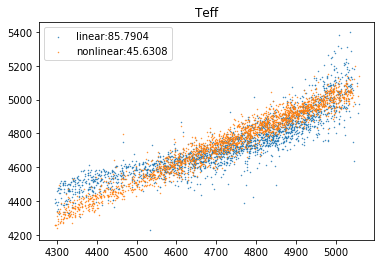

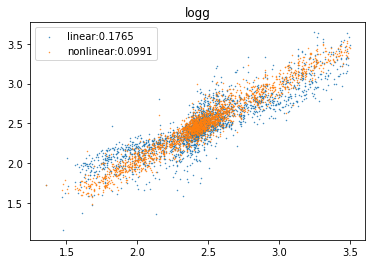

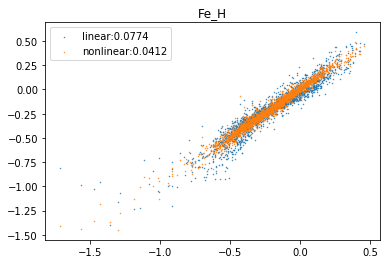

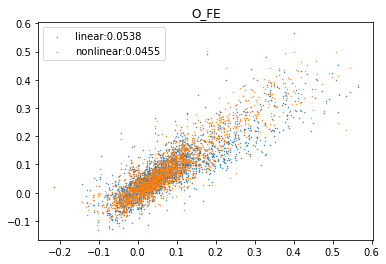

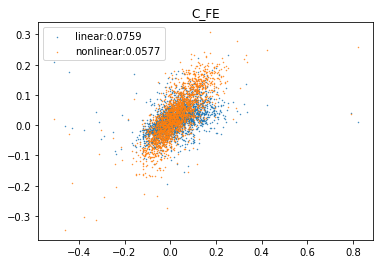

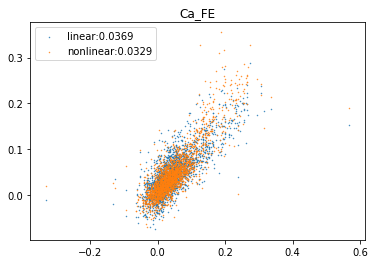

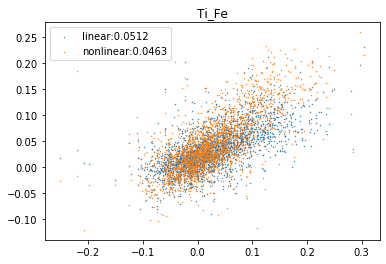

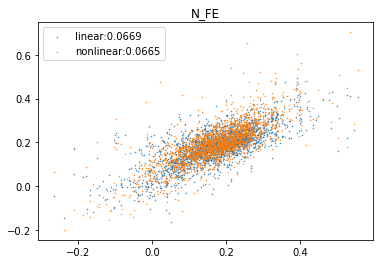

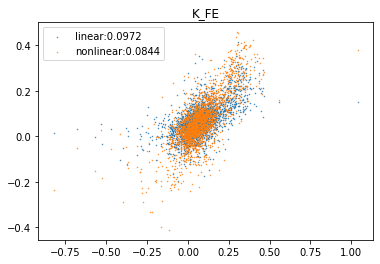

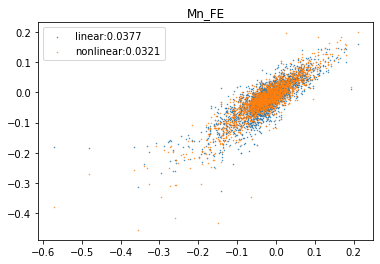

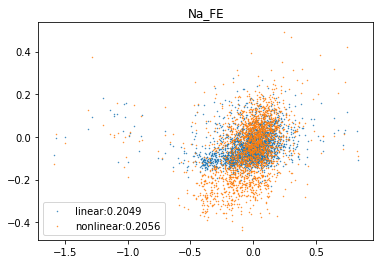

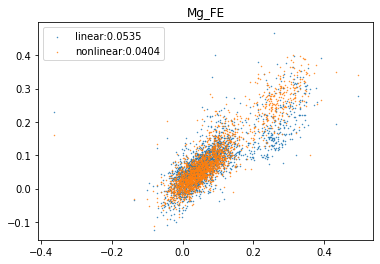

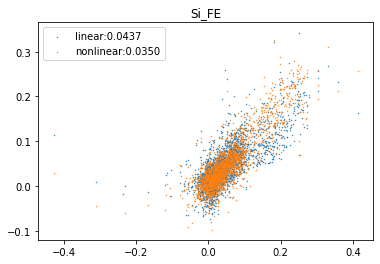

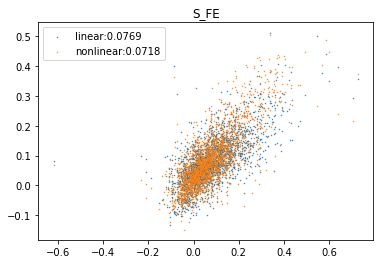

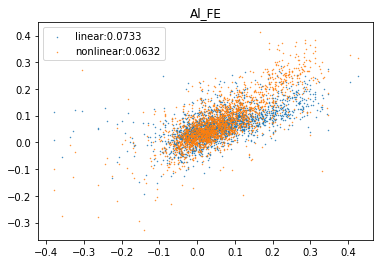

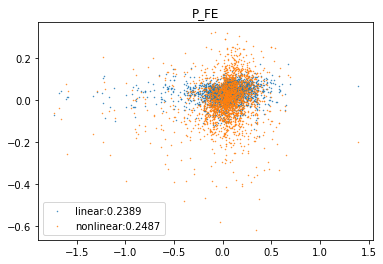

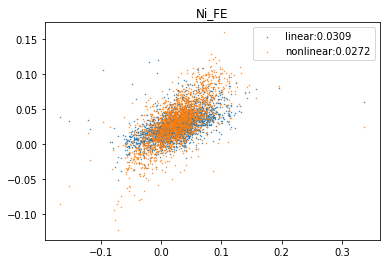

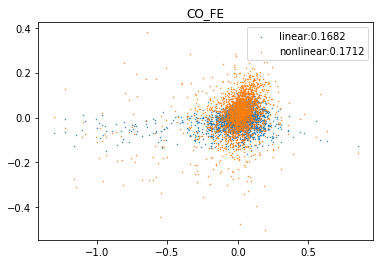

In [239]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z_cut_val).raw[:,i]-y_val.raw[:,i])
    linear_std = np.std(w.predict(z_cut_val).raw[:,i]-y_val.raw[:,i])

    plt.scatter(y_val.raw[:,i],w.predict(z_cut_val).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y_val.raw[:,i],nonlinear_w.predict(z_cut_val).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

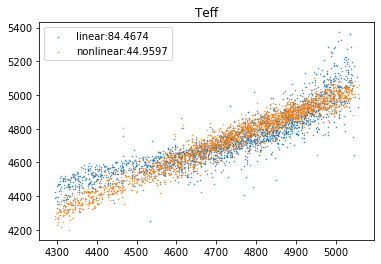

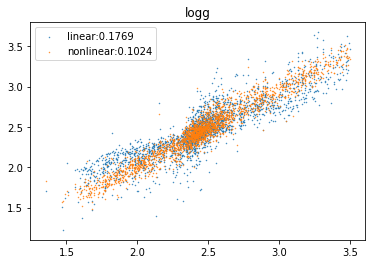

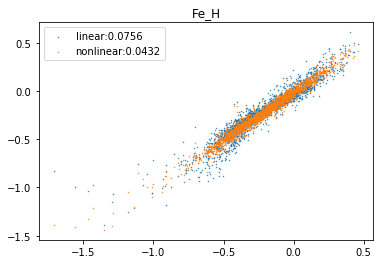

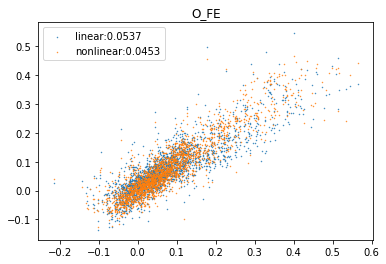

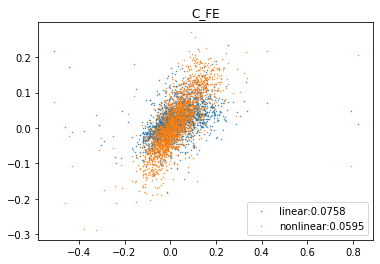

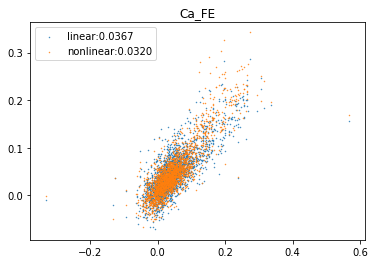

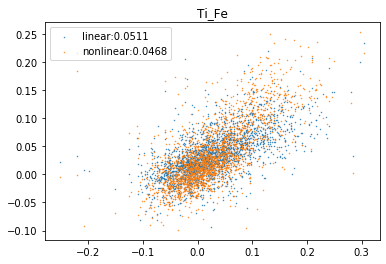

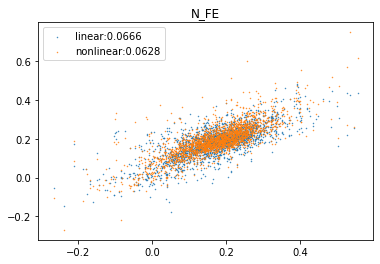

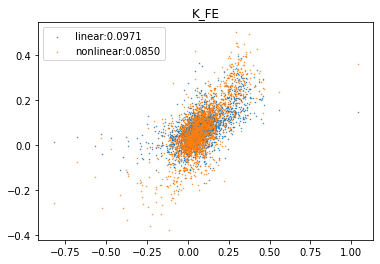

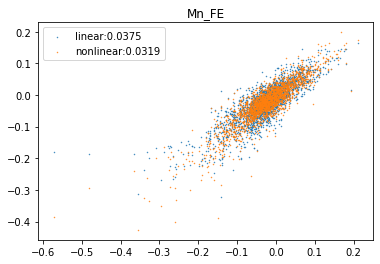

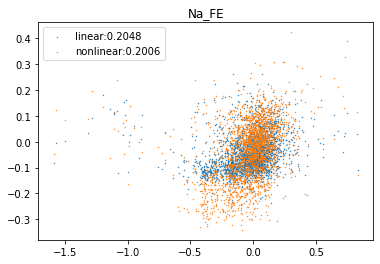

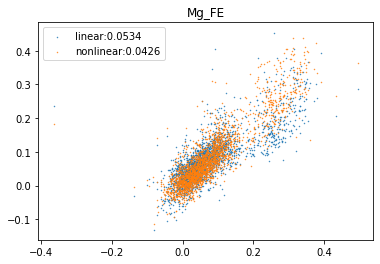

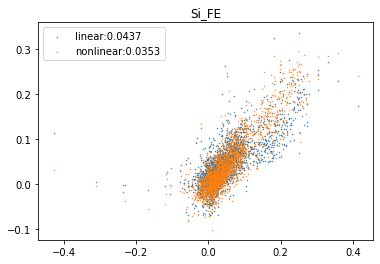

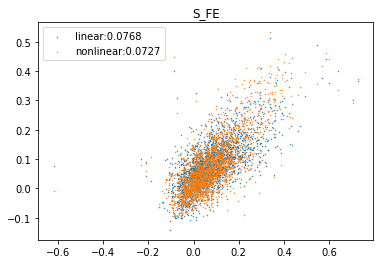

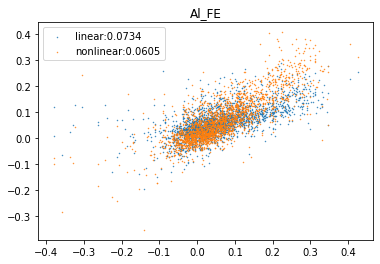

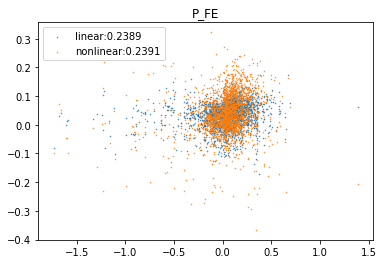

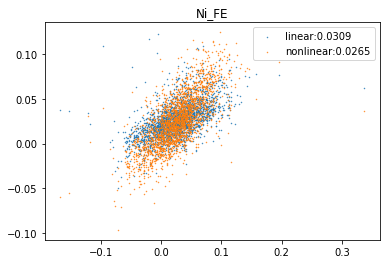

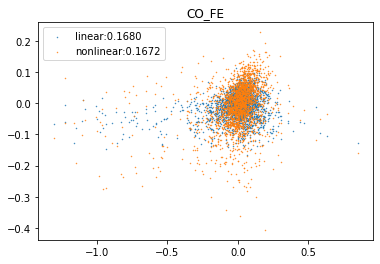

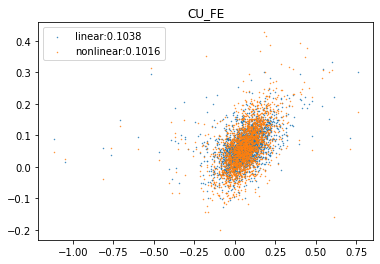

In [116]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z_cut_val).raw[:,i]-y_val.raw[:,i])
    linear_std = np.std(w.predict(z_cut_val).raw[:,i]-y_val.raw[:,i])

    plt.scatter(y_val.raw[:,i],w.predict(z_cut_val).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y_val.raw[:,i],nonlinear_w.predict(z_cut_val).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

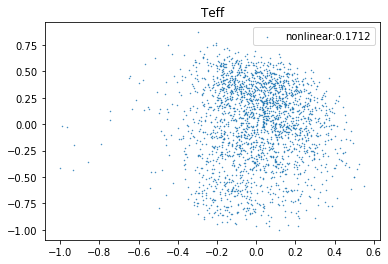

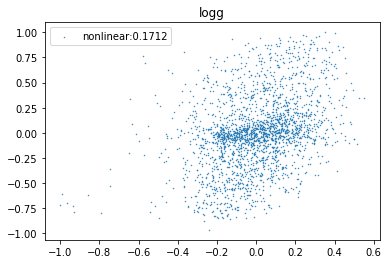

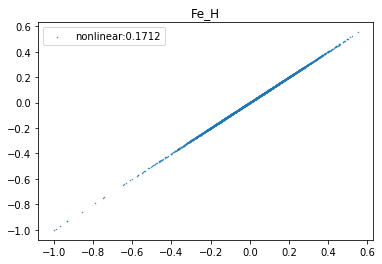

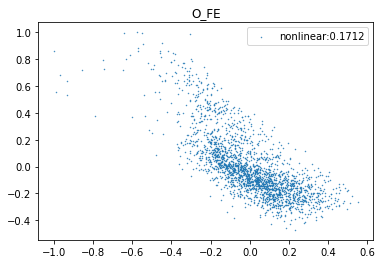

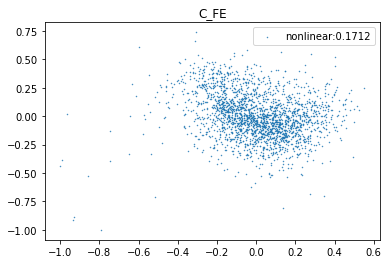

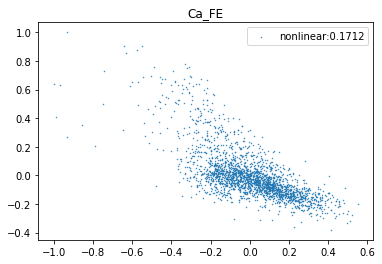

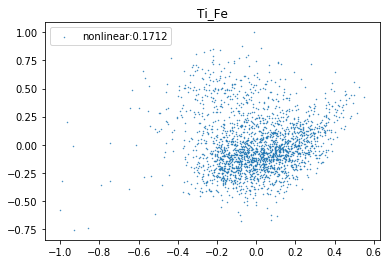

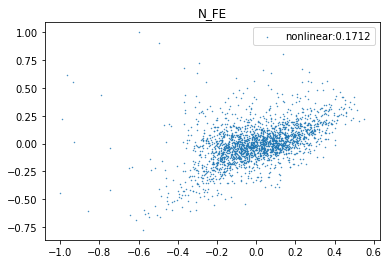

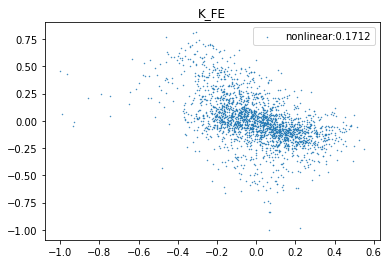

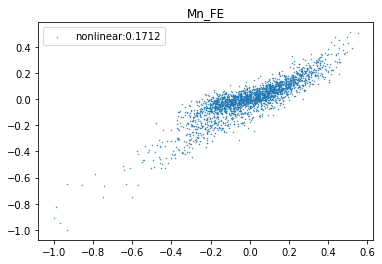

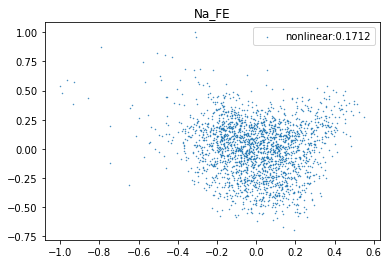

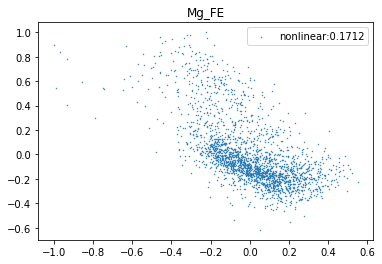

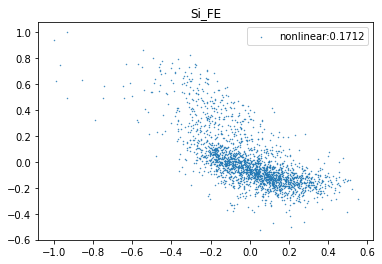

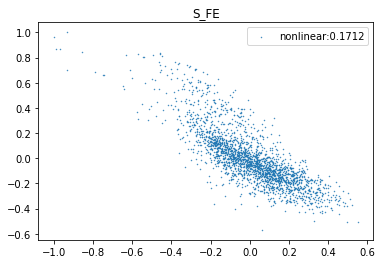

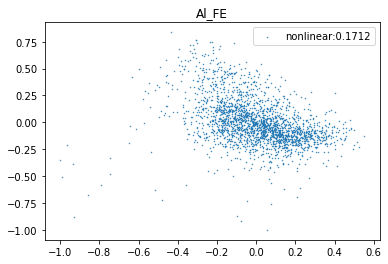

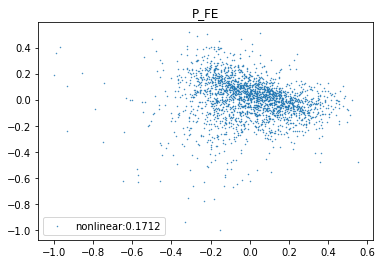

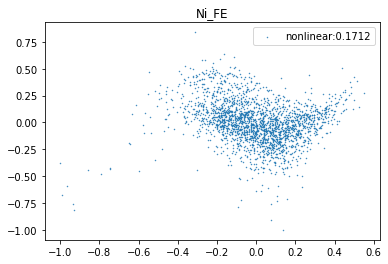

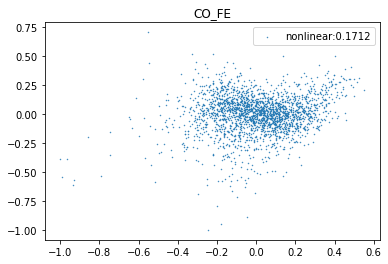

In [240]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    plt.scatter(nonlinear_w.predict(z_cut_val).normalized[:,2],nonlinear_w.predict(z_cut_val).normalized[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    #plt.scatter(nonlinear_w.predict(z_cut_train).normalized[:,2],nonlinear_w.predict(z_cut_train).normalized[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))


    plt.legend()
    plt.show()

In [ ]:
len(nonlinear_w.predict(z_cut_val).normalized[:,2])

In [2]:
allStar= apread.allStar(use_astroNN=True,rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)

/share/splinter/ddm/modules/apogee/apogee/tools/read.py:1422: UserWarning: Swapping in stellar parameters and abundances from Leung & Bovy (2019a)
  warnings.warn("Swapping in stellar parameters and abundances from Leung & Bovy (2019a)")


C
CI


ValueError: 'ci' is not in list

In [ ]:
from astropy.io import fits

In [3]:
hdul = fits.open("/share/splinter/ddm/modules/turbospectrum/spectra/dr16/apogee/vac/apogee-astronn/apogee_astroNN-DR16-v0.fits")



In [25]:
desired_ids= []
astroNN_ids = list(hdul[1].data["Apogee_id"])
for apogee_id in allStar[combined_cut]["APOGEE_ID"]:
    desired_ids.append(astroNN_ids.index(apogee_id))

In [29]:
cut_astroNN = hdul[1].data[desired_ids]

In [33]:
cut_astroNN["Fe_H"]

array([ 0.02216056, -0.00548813, -0.03914211, ..., -0.20013843,
       -0.01696945, -0.01696945], dtype=float32)

In [158]:
params = []
for i,p in enumerate(considered_parameters):
    fe_h = cut_astroNN["FE_H"]
    if i<=2:
        params.append(cut_astroNN[p])
    else:
        p_h = cut_astroNN[considered_parameters[i].split("_")[0]+"_H"]
        params.append(p_h-fe_h)

y_astronn = vector.Vector(np.array(params).T)

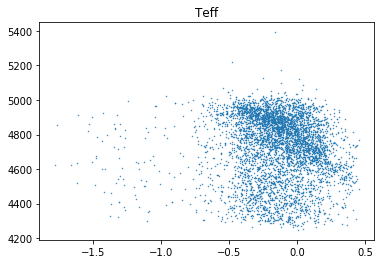

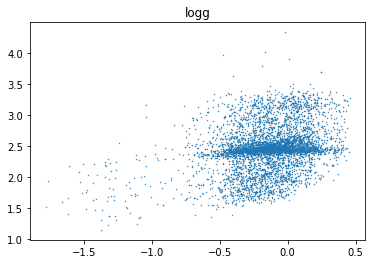

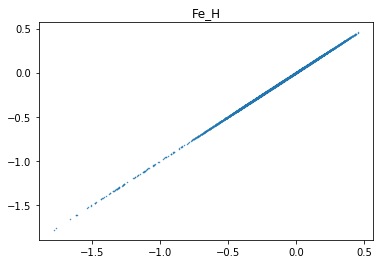

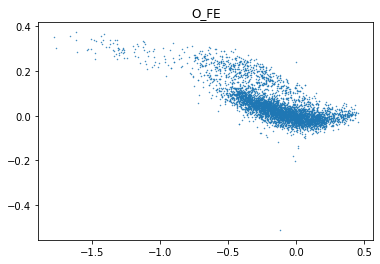

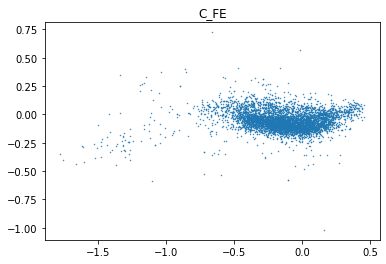

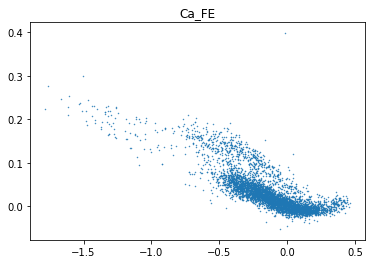

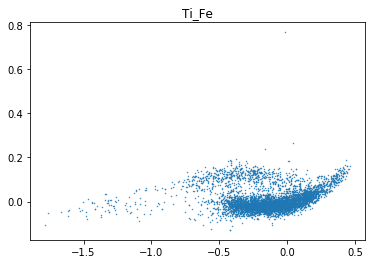

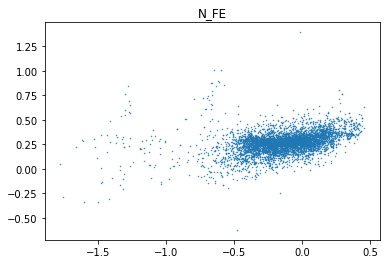

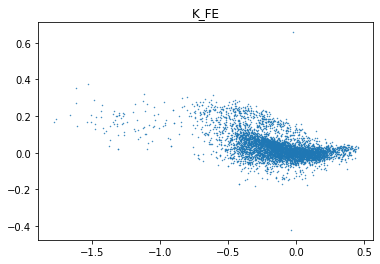

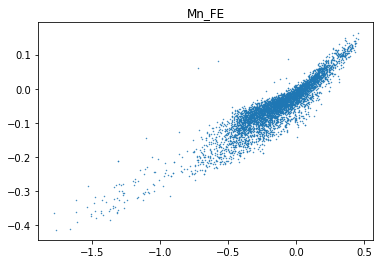

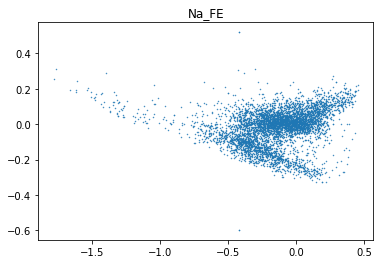

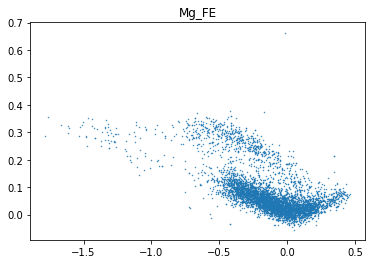

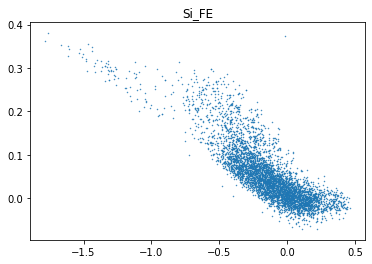

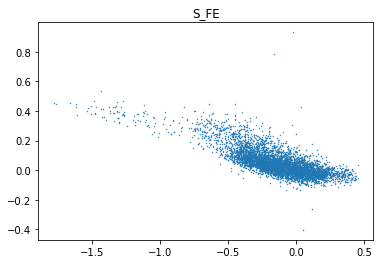

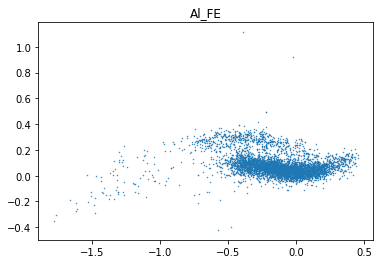

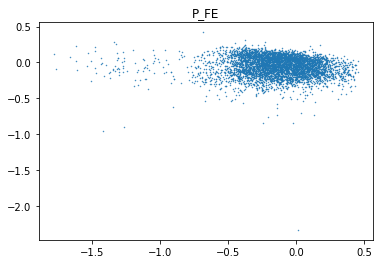

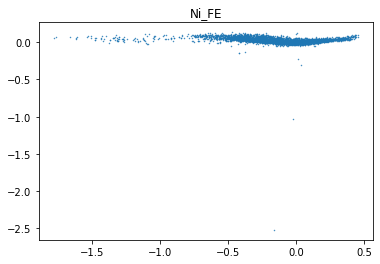

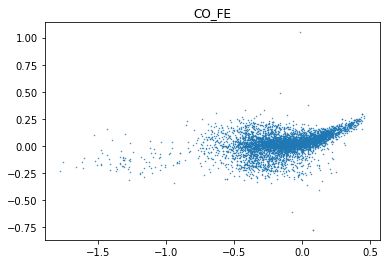

In [244]:
for d in range(len(considered_parameters)):
    plt.title(considered_parameters[d])
    plt.scatter(y_astronn.raw[:5000,2],y_astronn.raw[:5000,d],s=0.2,label="linear:{:.4f}".format(linear_std))
    #plt.scatter(nonlinear_w.predict(z_cut_train).raw[:,2],nonlinear_w.predict(z_cut_train).raw[:,d],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.show()

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti', 'LGVSINI', 'O'], ['C', 'CI', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'K', 'Ca', 'Ti', 'TiII', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Ge', 'Rb', 'Ce', 'Nd', 'Yb'], ['[C/M]', '[CI/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[P/H]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[TiII/M]', '[V/H]', '[Cr/H]', '[Mn/H]', '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]', '[Rb/H]', '[Ce/H]', '[Nd/H]', '[Yb/H]'], [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ['coarse', 'BA', 'GKg_a', 'GKg_b', 'GKg_c', 'GKg_d', 'GKd_a', 'GKd_b', 'GKd_c', 'GKd_d', 'Fd_a', 'Fd_b', 'Fd_c', 'Fd_d', 'Mg_a', 'Mg_b', 'Mg_c', 'Mg_d', 'Md_a', 'Md_b', 'Md_c', 'Md_d'])]


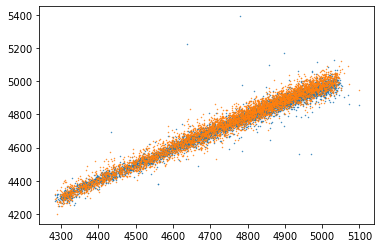

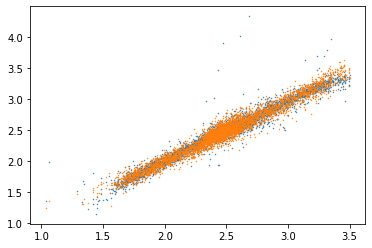

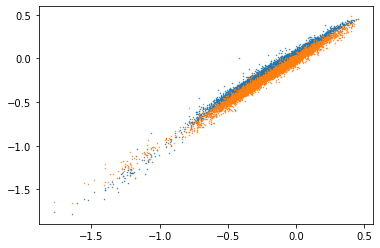

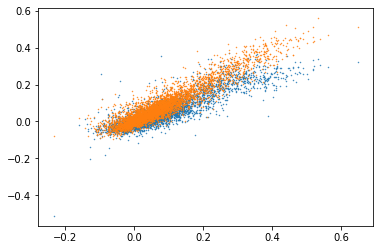

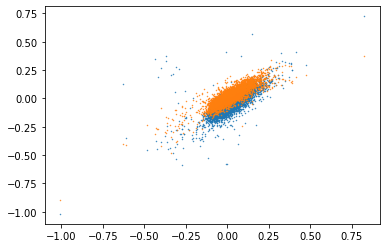

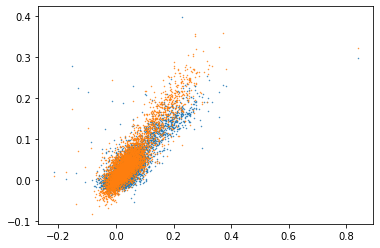

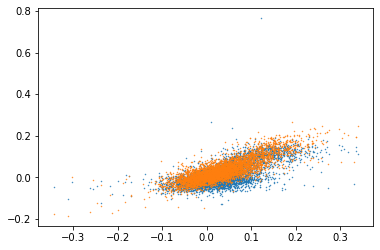

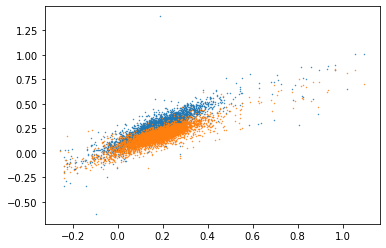

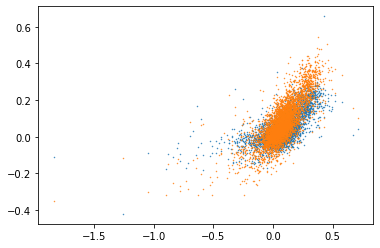

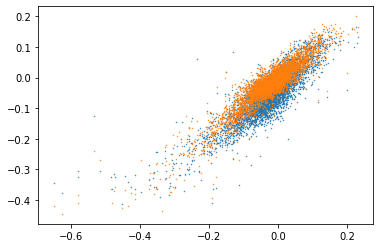

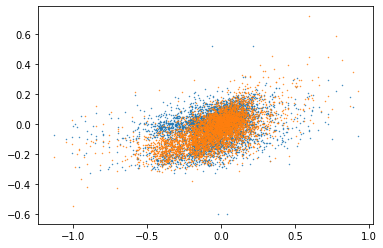

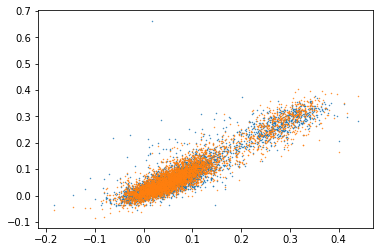

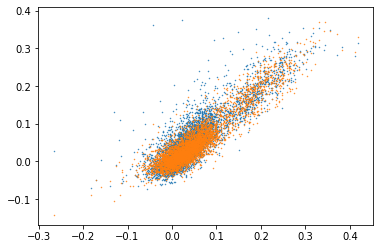

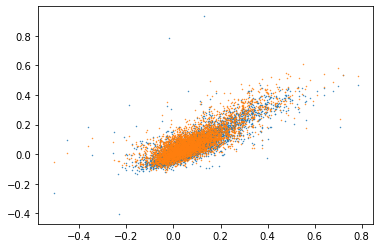

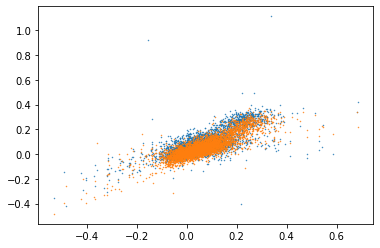

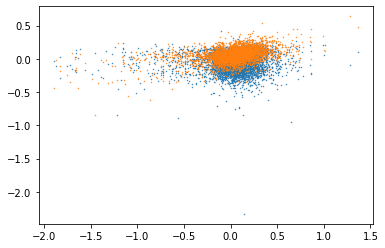

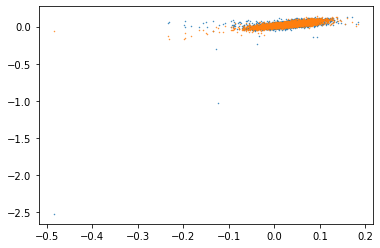

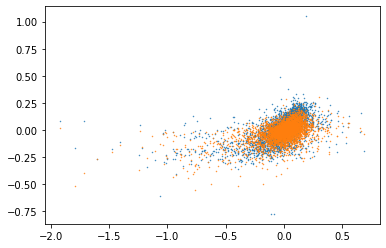

In [188]:
for d in range(len(considered_parameters)):
    plt.scatter(y_train.raw[:5000,d],y_astronn.raw[:5000,d],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y_train.raw[:5000,d],nonlinear_w.predict(z_cut_train).raw[:,d],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.show()

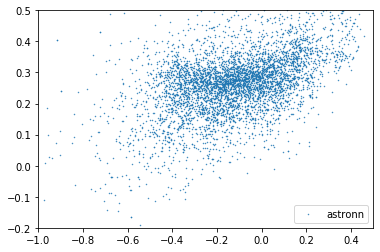

In [215]:
d=7
plt.scatter(y_astronn.raw[:5000,2],y_astronn.raw[:5000,d],s=0.2,label="astronn")
#plt.scatter(nonlinear_w.predict(z_cut_train).raw[:,2],nonlinear_w.predict(z_cut_train).raw[:,d],s=0.2,label="ae")
plt.xlim(-1,0.5)
plt.ylim(-0.2,0.5)

plt.legend()
plt.show()

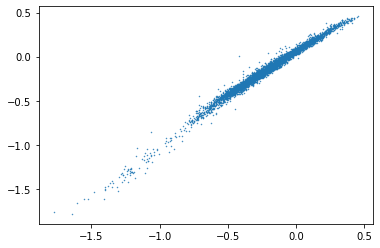

In [216]:
plt.scatter(y_train.raw[:,2],cut_astroNN["Fe_H"][:5000],s=0.2,label="linear:{:.4f}".format(linear_std))


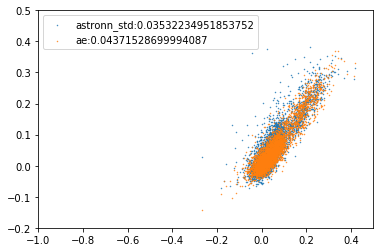

In [231]:
d=12
astronn_std = np.std(y_train.raw[:5000,d]-y_astronn.raw[:5000,d])
ae_std = np.std(w.predict(z_cut_val).raw[:,d]-y_val.raw[:,d])
plt.scatter(y_train.raw[:5000,d],y_astronn.raw[:5000,d],s=0.2,label=f"astronn_std:{astronn_std}")
plt.scatter(y_train.raw[:5000,d],nonlinear_w.predict(z_cut_train).raw[:,d],s=0.2,label=f"ae:{ae_std}")
plt.xlim(-1,0.5)
plt.ylim(-0.2,0.5)

plt.legend()
plt.show()

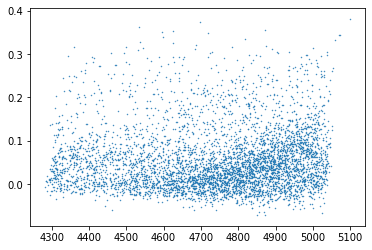

In [275]:
plt.scatter(y_train.raw[:5000,0],y_astronn.raw[:5000,12],s=0.2,label=f"astronn_std:{astronn_std}")
